# Préparation des variables pour les variables de style

In [ ]:
library(tidyverse)
library(factoextra)

# Charger les données
df_pilot1_2022 <- readRDS("../../../data/qc2022/preparation_donnees/01_pilot1_2022.rds")

In [2]:
# Préparation du jeu de données pour les variables de style
variables_style <- c(
  "id",
  "app_swag_Formel",
  "app_swag_Classique",
  "app_swag_Casual",
  "app_swag_Sport",
  "app_swag_Chic",
  "app_swag_HippBoheme",
  "app_swag_Punk",
  "app_swag_Rock",
  "app_swag_Other",
  "app_noTattoo",
  "animal_cat",
  "animal_dog",
  "animal_domestic",
  "animal_farm",
  "animal_noPet"
)

df_style <- df_pilot1_2022 %>%
  select(all_of(variables_style))

In [ ]:
# Boucle pour afficher la table pour chaque variable
for (v in variables_style) {
  if (v != "id") {
    cat("Table pour la variable:", v, "\n")
    print(table(df_style[[v]]))
    cat("\n\n")
  }
}

## Transformations

- app_swag

Les variables app_swag sont telles que certaines catégories sont très peu peuplées. Regrouper les styles pour en faire des styles plus généraux.

- noTatoo

Retourner le sens logique pour que vrai soit avec tatou => deviendra Tatoo

- animal

Regrouper certaines classes d'animal pour avoir des catégories plus générales


In [4]:
# Regroupement de app_swag
#-------------------------

df_style <- df_style %>%

  # Regrouper Formel et Chic sous Classique
  mutate(
    app_swag_Classique = if_else(
      app_swag_Formel == 1 | app_swag_Chic == 1,
      1,
      app_swag_Classique
    )
  ) %>%
  select(-app_swag_Formel, -app_swag_Chic) %>%

  # Regrouper HippBoheme, Punk, Rock sous Other
  mutate(
    app_swag_Other = if_else(
      app_swag_HippBoheme == 1 | app_swag_Punk == 1 | app_swag_Rock == 1,
      1,
      app_swag_Other
    )
  ) %>%
  select(-app_swag_HippBoheme, -app_swag_Punk, -app_swag_Rock)

In [5]:
# Changement de sens logique de NoTatoo
#--------------------------------------

df_style <- df_style %>%
  mutate(app_withTattoo = if_else(app_noTattoo == 1, 0, 1)) %>%
  select(-app_noTattoo)

In [6]:
# Regroupement de animal
#-----------------------

df_style <- df_style %>%
  mutate(animal_other = if_else(
    animal_domestic == 1 | animal_farm == 1,
    1,
    0
  )
  ) %>%
  select(-animal_domestic, -animal_farm)

In [7]:
variables_style_clust <- c(
  "id",
  "app_swag_Classique",
  "app_swag_Casual",
  "app_swag_Sport",
  "app_swag_Other",
  "app_withTattoo",
  "animal_cat",
  "animal_dog",
  "animal_other",
  "animal_noPet"
)

In [ ]:
# Boucle pour afficher la table pour chaque variable
for (v in variables_style_clust) {
  if (v != "id") {
    cat("Table pour la variable:", v, "\n")
    print(table(df_style[[v]]))
    cat("\n\n")
  }
}

In [9]:
# Sauvegarder les données préparées
saveRDS(df_style, file = "../../../data/qc2022/preparation_donnees/02_pilot1_2022_style.rds")

---

### Activité de Clustering

Effectuer un exercice de clustering pour mieux saisir les données et leur relation. 

Cet exercice est purement exploratoire et sert à voir si les données peuvent être utilisées pour faire du clustering.

In [2]:
df_style <- readRDS(file = "../../../data/qc2022/preparation_donnees/02_pilot1_2022_style.rds")

In [4]:
library(dplyr)

# Exploration des données
df_clust <- df_style %>% select(-id)

# Aperçu et exploration initiale :

# Aperçu des données
head(df_clust)

# # Vérification des données manquantes
sum(is.na(df_clust))

# # Statistiques descriptives
summary(df_clust)




Attachement du package : 'dplyr'


Les objets suivants sont masqu'es depuis 'package:stats':

    filter, lag


Les objets suivants sont masqu'es depuis 'package:base':

    intersect, setdiff, setequal, union




,app_swag_Classique,app_swag_Casual,app_swag_Sport,app_swag_Other,animal_cat,animal_dog,animal_noPet,app_withTattoo,animal_other
,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
1,0,1,0,0,0,1,0,0,0
2,0,1,0,0,0,1,0,0,0
3,1,0,0,0,0,0,1,1,0
4,0,1,0,0,0,0,1,0,0
5,0,1,0,0,1,0,0,1,0
6,0,1,0,0,0,1,0,0,0


[1] 0

 app_swag_Classique app_swag_Casual  app_swag_Sport    app_swag_Other
 Min.   :0.0000     Min.   :0.0000   Min.   :0.00000   Min.   :0.00  
 1st Qu.:0.0000     1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:0.00  
 Median :0.0000     Median :1.0000   Median :0.00000   Median :0.00  
 Mean   :0.1813     Mean   :0.6807   Mean   :0.08267   Mean   :0.06  
 3rd Qu.:0.0000     3rd Qu.:1.0000   3rd Qu.:0.00000   3rd Qu.:0.00  
 Max.   :1.0000     Max.   :1.0000   Max.   :1.00000   Max.   :1.00  
   animal_cat       animal_dog      animal_noPet    app_withTattoo 
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.000  
 Median :0.0000   Median :0.0000   Median :0.0000   Median :0.000  
 Mean   :0.3647   Mean   :0.2407   Mean   :0.4593   Mean   :0.252  
 3rd Qu.:1.0000   3rd Qu.:0.0000   3rd Qu.:1.0000   3rd Qu.:1.000  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.000  
  animal_other    
 Min.   :0.0000

In [6]:
# Analyser la distribution des variables pour décider quelle méthode utiliser

# Calcul de la variance pour chaque colonne
variances <- apply(df_clust, 2, var)

# Calcul de l'écart-type pour chaque colonne
std_devs <- apply(df_clust, 2, sd)

# Afficher les résultats
print(variances)
print(std_devs)

# Calcul du ratio max/min
ratio_var <- max(variances) / min(variances)

# Afficher le ratio
print(ratio_var)

# Test de Bartlett sur les colonnes
library(car)
bartlett.test(df_clust)

app_swag_Classique    app_swag_Casual     app_swag_Sport     app_swag_Other 
        0.14855059         0.21750456         0.07588348         0.05643763 
        animal_cat         animal_dog       animal_noPet     app_withTattoo 
        0.23183945         0.18286813         0.24851190         0.18862175 
      animal_other 
        0.05702424 
app_swag_Classique    app_swag_Casual     app_swag_Sport     app_swag_Other 
         0.3854226          0.4663738          0.2754696          0.2375660 
        animal_cat         animal_dog       animal_noPet     app_withTattoo 
         0.4814971          0.4276308          0.4985097          0.4343061 
      animal_other 
         0.2387975 
[1] 4.403302


Le chargement a n'ecessit'e le package : carData


Attachement du package : 'car'


L'objet suivant est masqu'e depuis 'package:dplyr':

    recode





	Bartlett test of homogeneity of variances

data:  df_clust
Bartlett's K-squared = 1903.9, df = 8, p-value < 2.2e-16


### Clustering avec kmeans

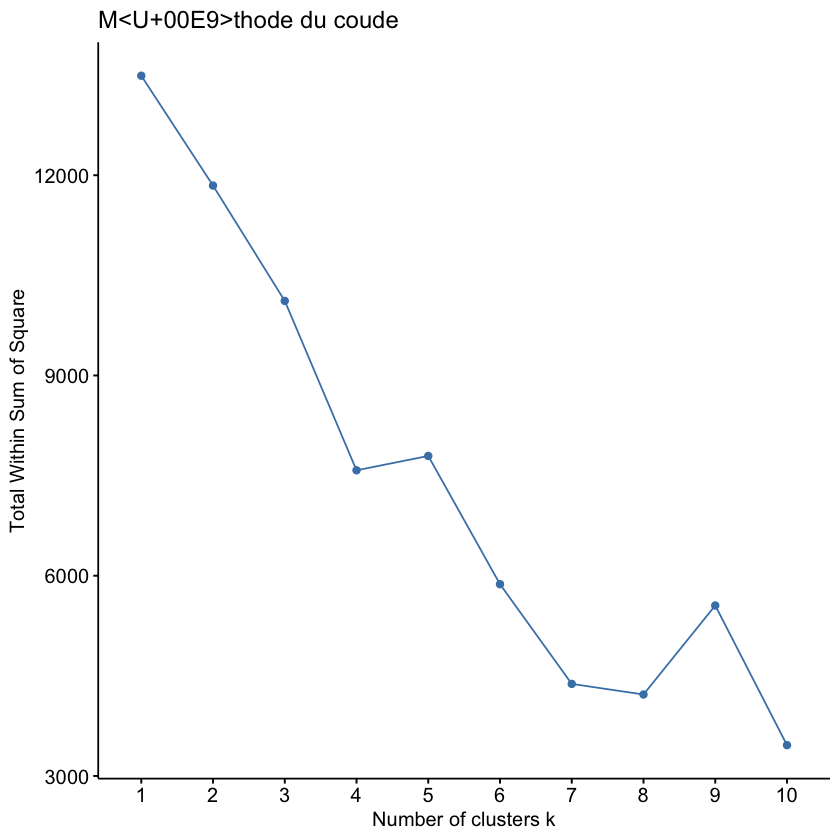

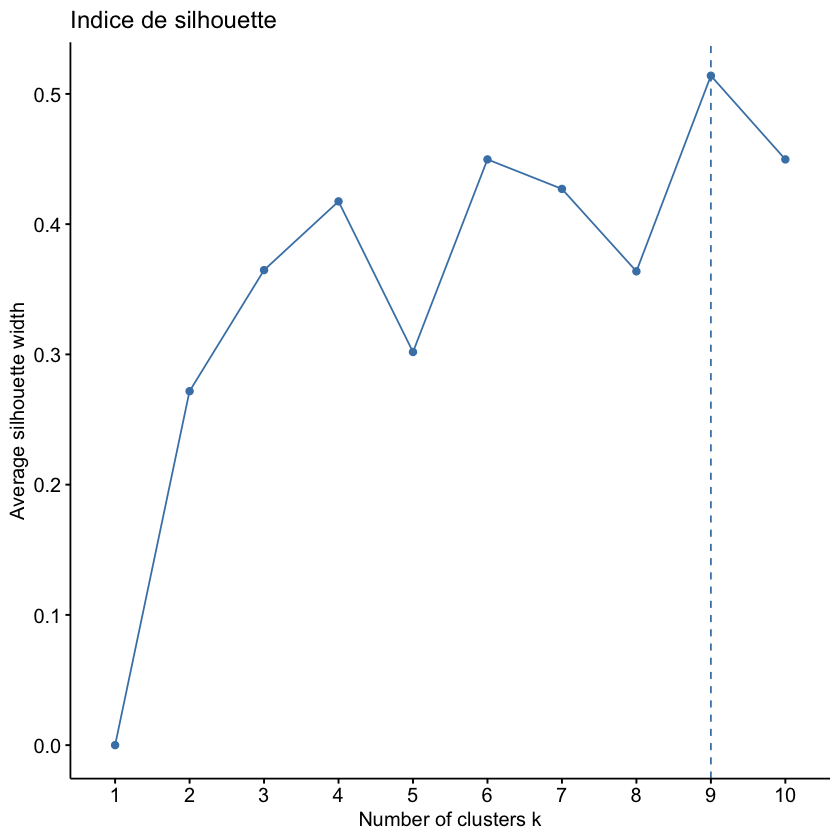

In [9]:
library(factoextra)

## Clustering avec k-means
df_scaled <- scale(df_clust)

# Utilisons la méthode de l’élbow (coude) et l’indice de silhouette.

# Méthode du coude
fviz_nbclust(df_scaled, kmeans, method = "wss") +
  ggtitle("Méthode du coude")

# Indice de silhouette
fviz_nbclust(df_scaled, kmeans, method = "silhouette") +
  ggtitle("Indice de silhouette")

In [11]:
# Application de K-Means Clustering

# Choisissez un nombre de clusters approprié (par exemple, 3).
k <- 4

# K-Means Clustering
set.seed(123)  # Pour la reproductibilité
kmeans_result <- kmeans(df_scaled, centers = k, nstart = 25)

# Ajouter les clusters au dataframe original
df_style$cluster_kmeans <- as.factor(kmeans_result$cluster)

In [12]:
kmeans_result

K-means clustering with 4 clusters of sizes 473, 548, 124, 355

Cluster means:
  app_swag_Classique app_swag_Casual app_swag_Sport app_swag_Other  animal_cat
1         -0.4704792       0.6847154     -0.3000937     -0.2258635 -0.75736006
2         -0.4704792       0.6847154     -0.3000937     -0.2371987  0.67521562
3         -0.4704792      -1.4594872      3.3300715     -0.1846685 -0.05390892
4          1.5174612      -1.4594872     -0.3000937      0.7315979 -0.01437223
   animal_dog animal_noPet app_withTattoo animal_other
1 -0.56279072   1.08456604   -0.215142367  -0.25405069
2  0.49122571  -0.92141308    0.205479236   0.18916761
3  0.02182568  -0.01548702   -0.078880007   0.04989156
4 -0.01605088  -0.01730981   -0.002983552   0.02905796

Clustering vector:
   [1] 2 2 4 1 2 2 3 2 1 4 2 4 4 2 2 1 2 4 3 2 4 1 2 1 3 4 4 4 4 4 3 1 2 2 4 4 2
  [38] 2 2 2 3 4 1 2 2 3 1 1 2 2 2 2 1 4 4 1 2 2 3 2 2 2 2 1 1 1 2 2 3 3 1 1 4 2
  [75] 2 4 1 4 3 1 4 1 4 2 2 1 4 2 2 2 4 1 1 4 1 3 1 1 2 2 4 4 1 1 3 

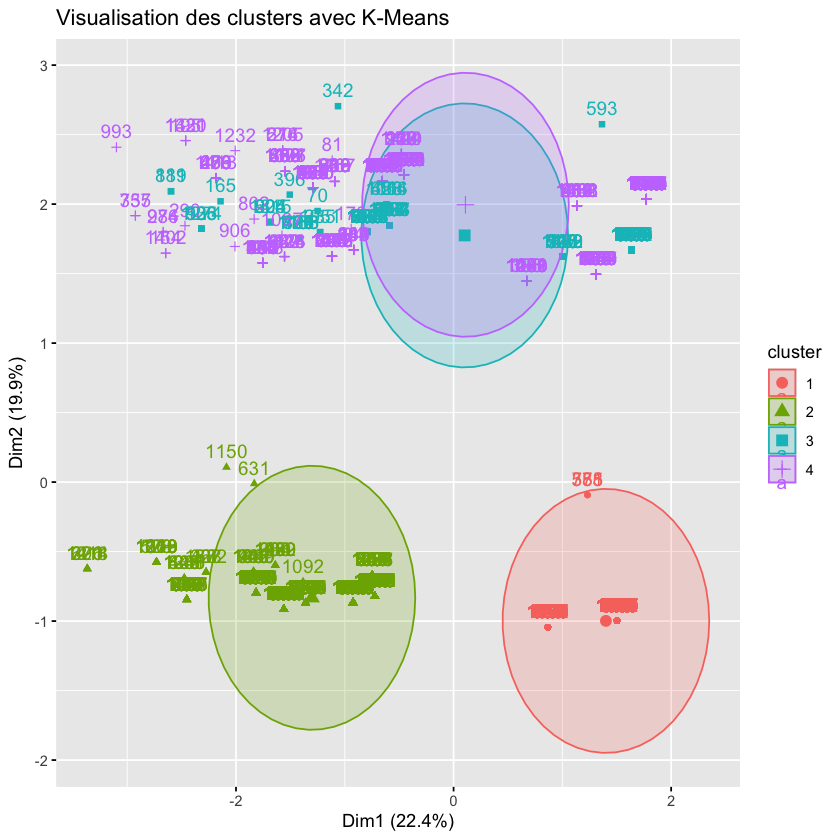

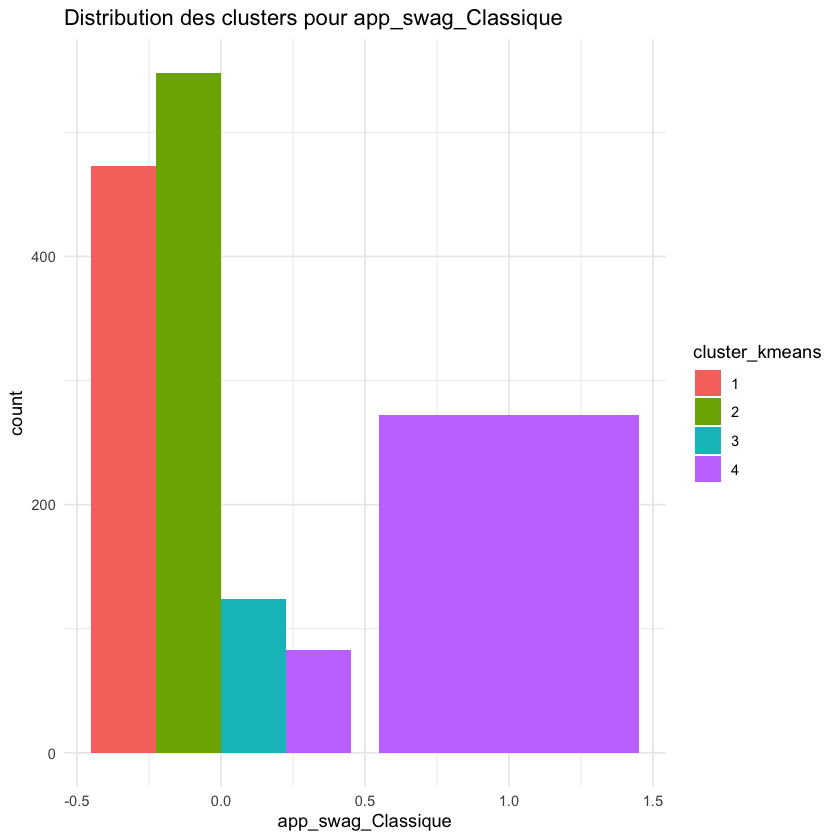

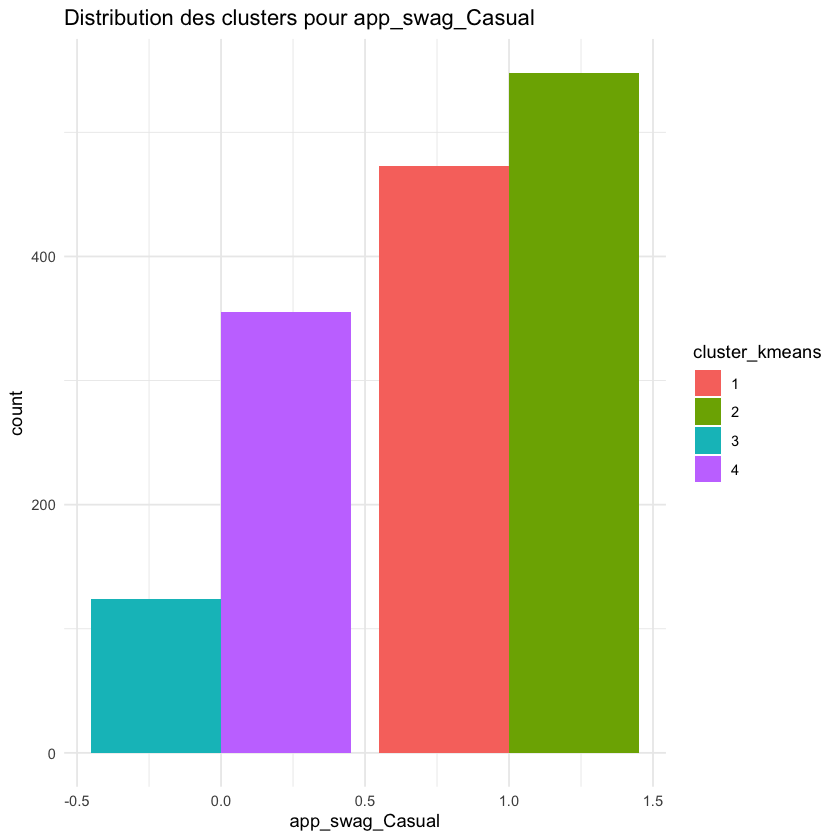

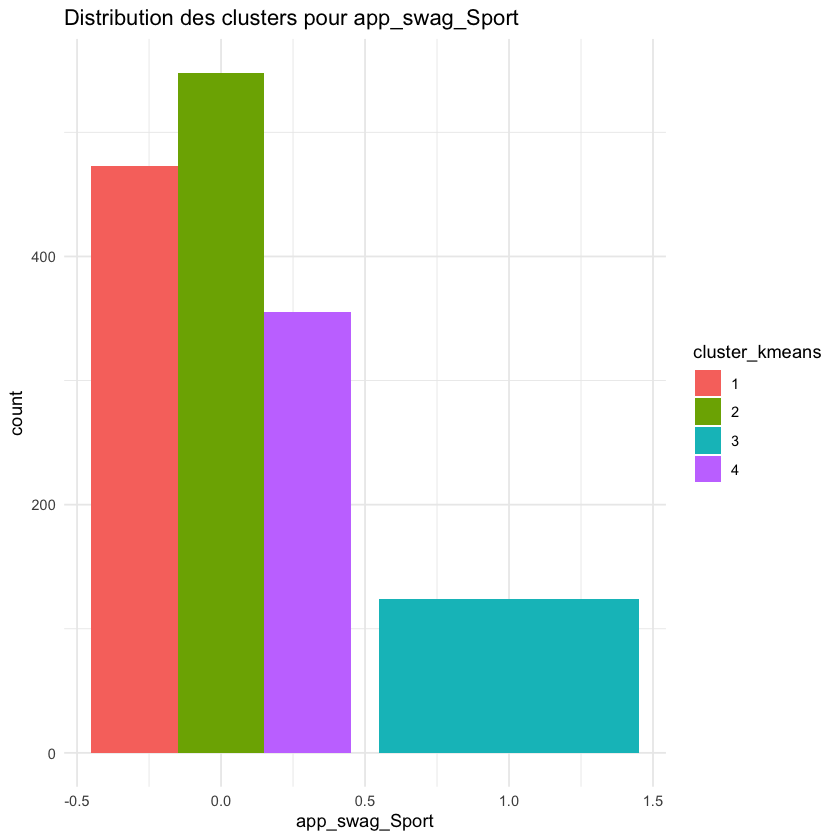

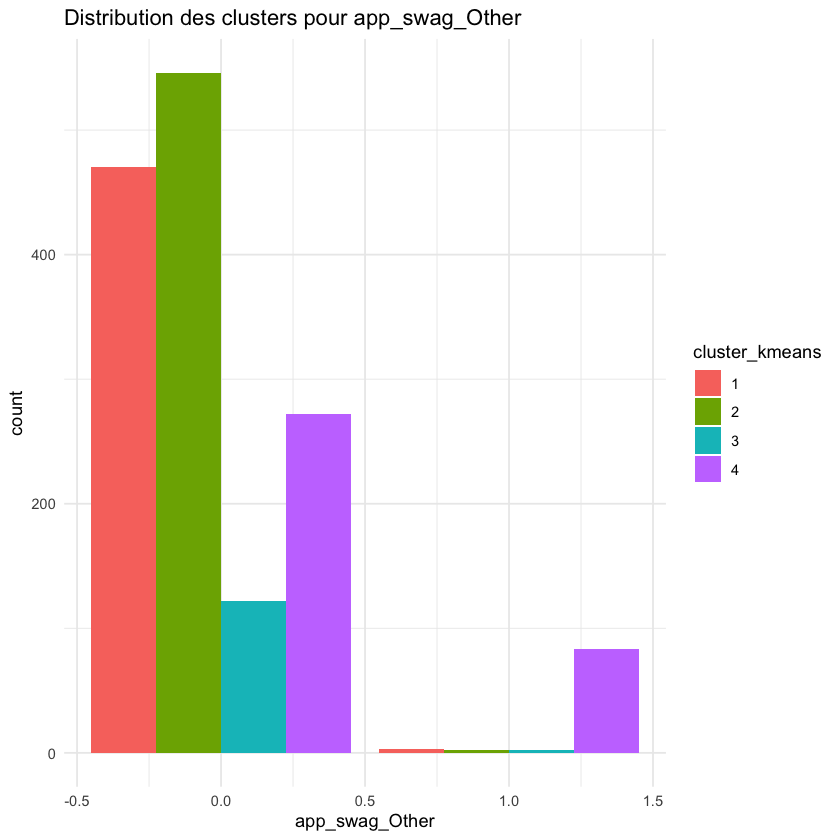

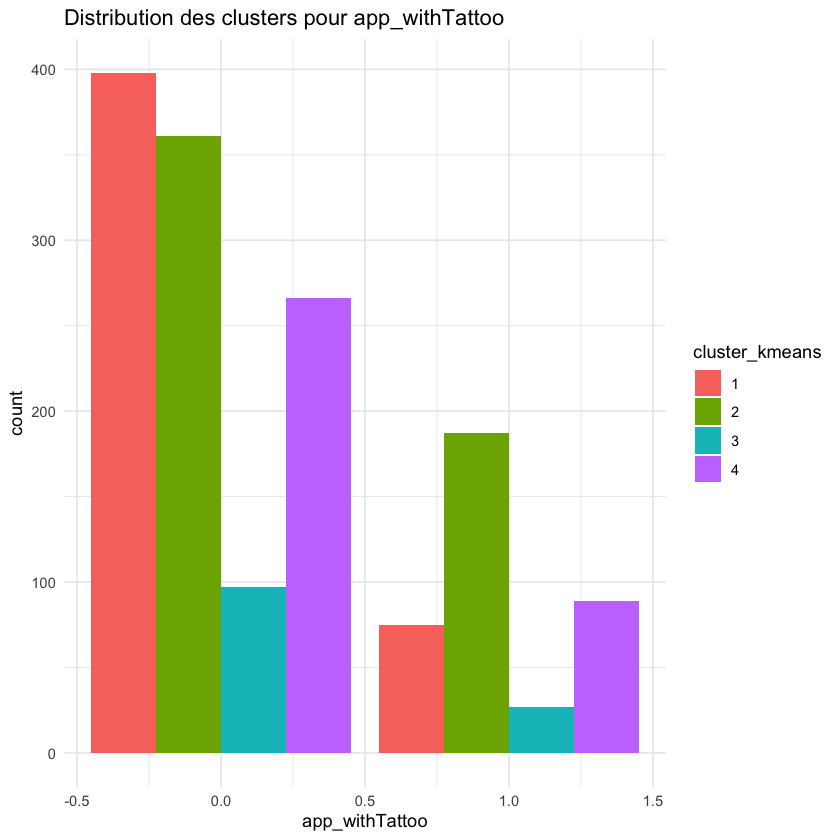

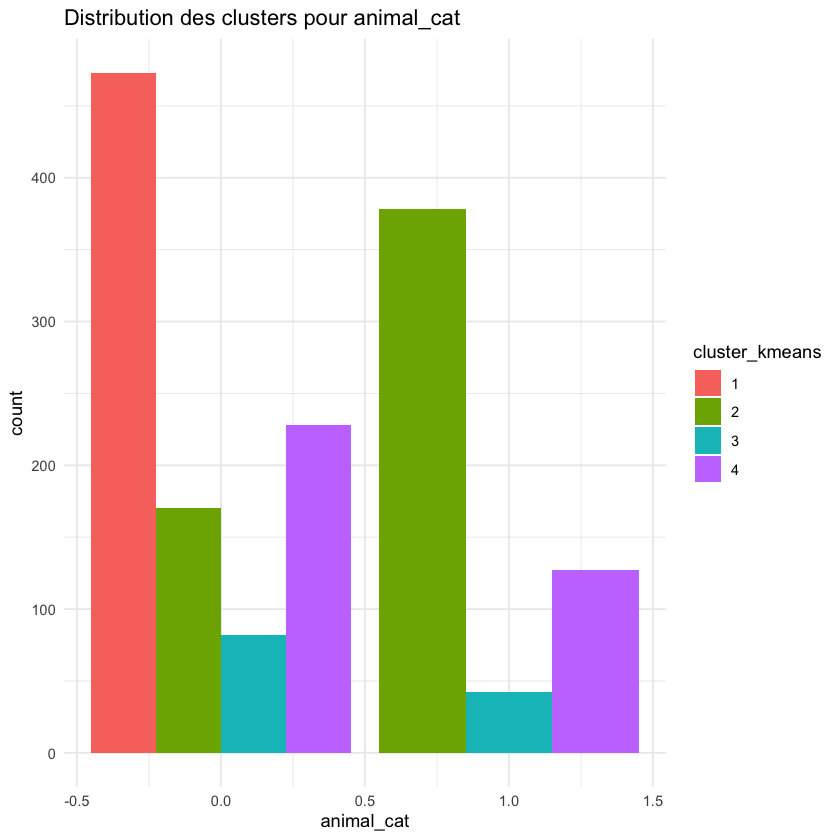

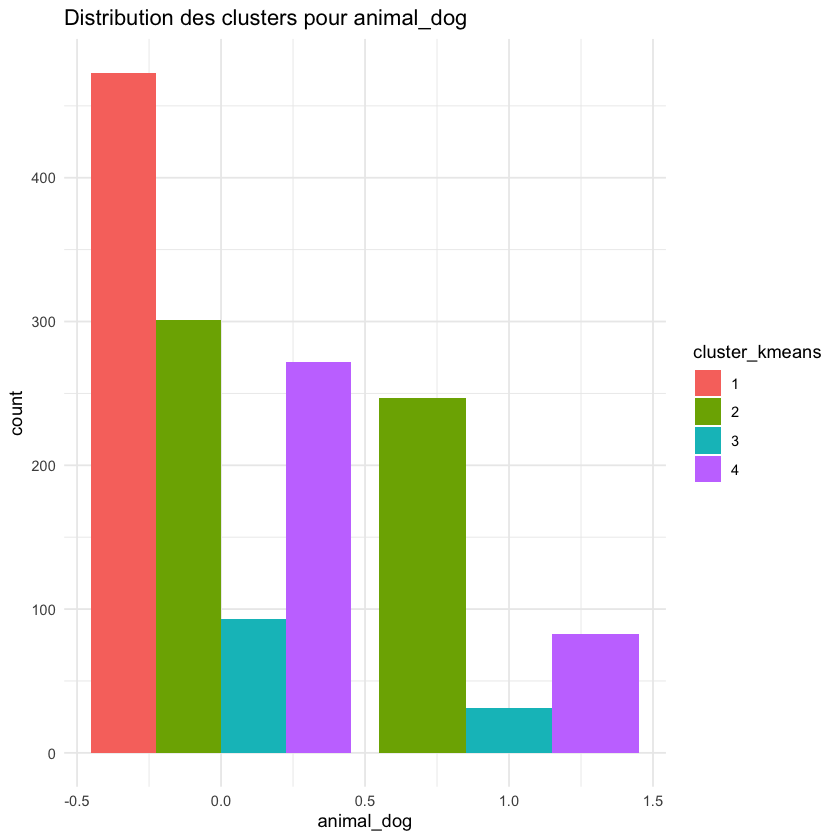

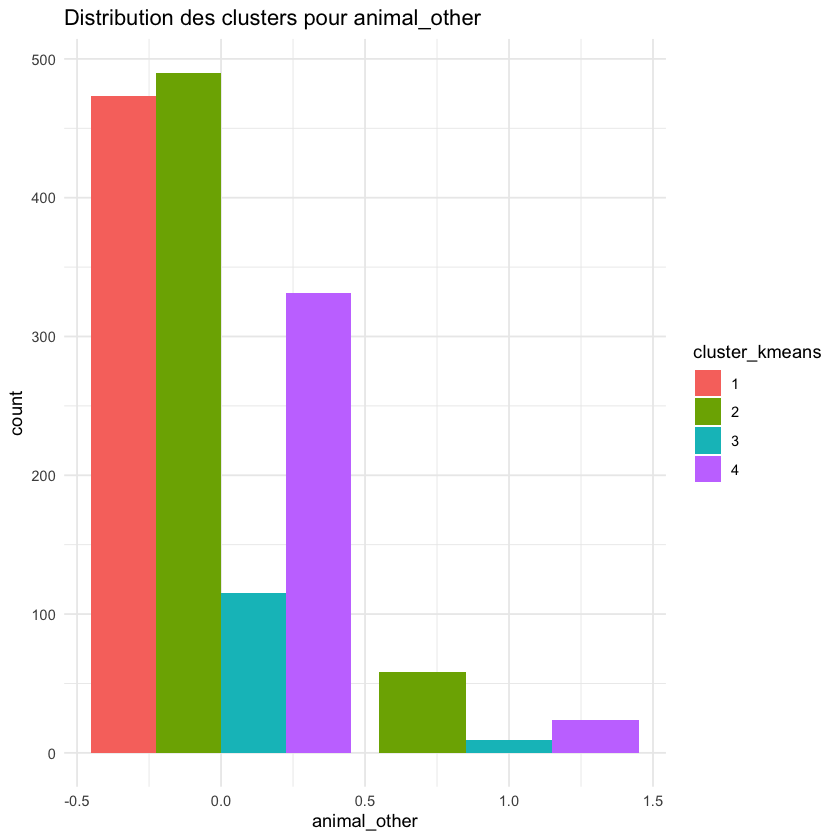

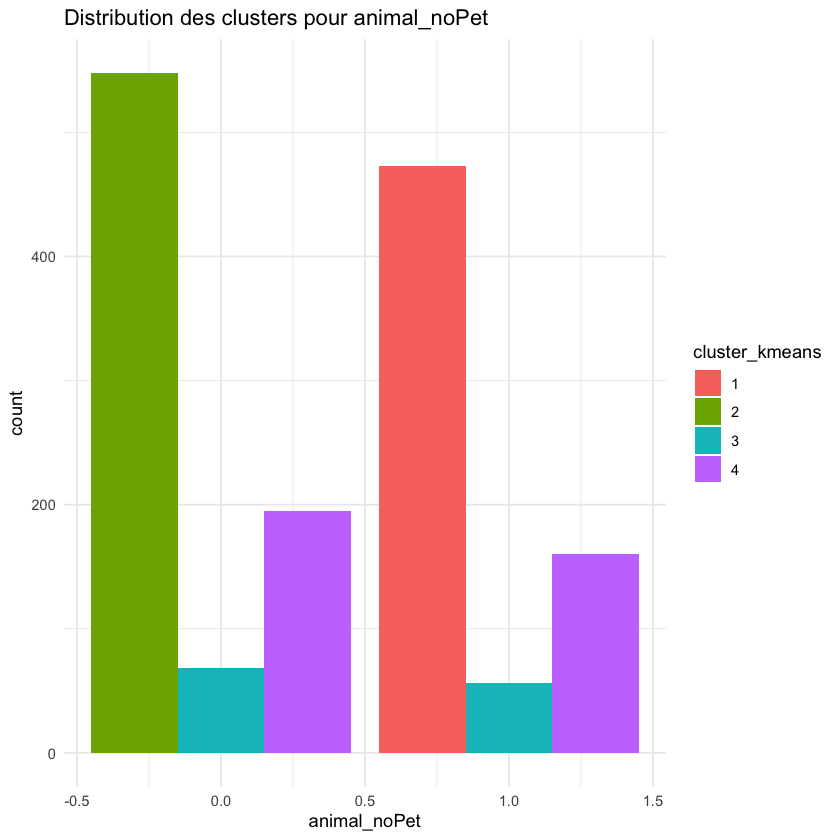

In [16]:
# Visualisation des clusters

# Visualisation des clusters dans l’espace des deux premières dimensions :

# Utilisation de factoextra pour représenter les clusters
fviz_cluster(kmeans_result, data = df_scaled, ellipse.type = "euclid") +
  ggtitle("Visualisation des clusters avec K-Means")

# Graphique par variables

# Variables binaires
g_var_bin <- function(df, nom_var) {
  # Distribution des clusters par var
  g <- ggplot(df, aes(x = .data[[nom_var]], fill = cluster_kmeans)) +
    geom_bar(position = "dodge") +
    ggtitle(paste("Distribution des clusters pour", nom_var)) +
    theme_minimal()
  return(g)
}
g_var_bin(df_style, "app_swag_Classique")
g_var_bin(df_style, "app_swag_Casual")
g_var_bin(df_style, "app_swag_Sport")
g_var_bin(df_style, "app_swag_Other")
g_var_bin(df_style, "app_withTattoo")
g_var_bin(df_style, "animal_cat")
g_var_bin(df_style, "animal_dog")
g_var_bin(df_style, "animal_other")
g_var_bin(df_style, "animal_noPet")

### Clustering avec kmodes

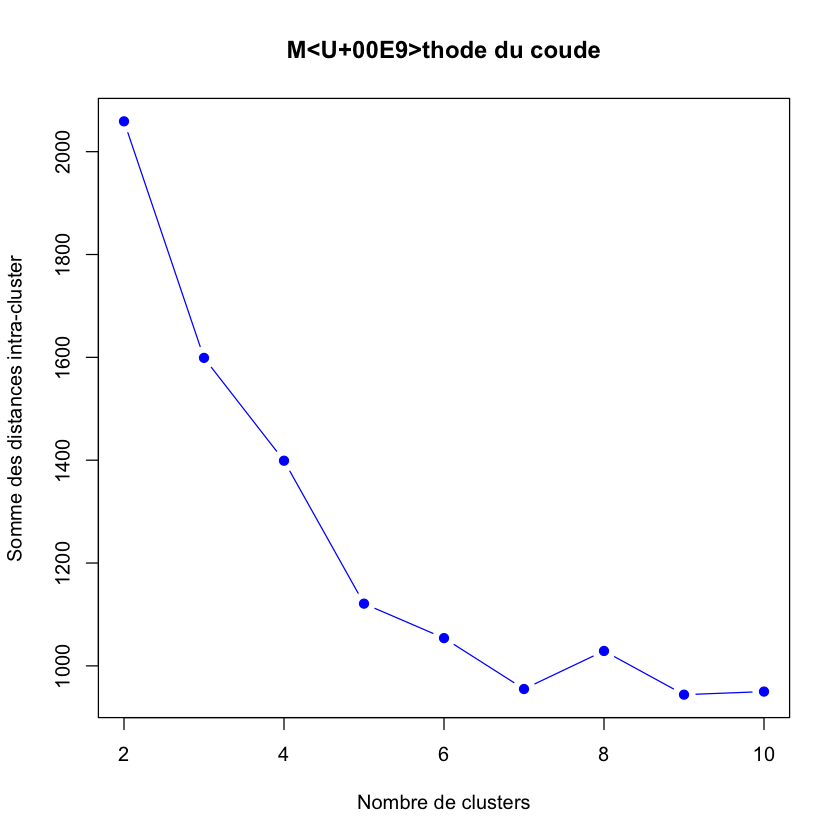

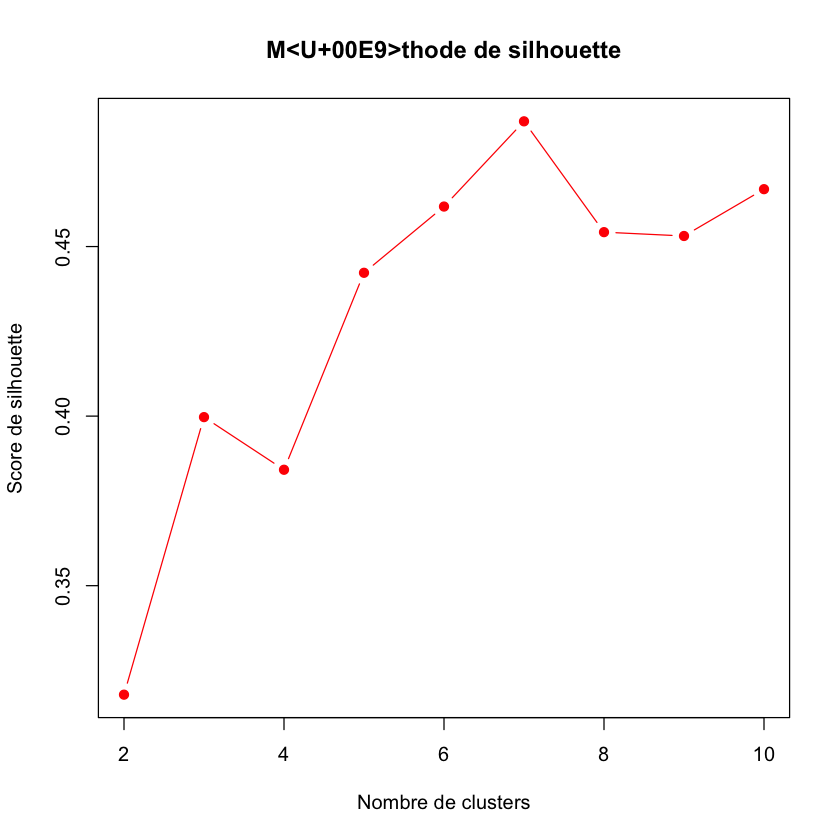

In [73]:
library(cluster)
library(klaR)

# Créer un échantillon de données catégorielles (exemple)
set.seed(123)

# Appliquer KModes pour différents nombres de clusters
n <- 10
wss <- numeric(n)  # Stocker l'inertie pour différents k

# Calculer la silhouette pour différents nombres de clusters
sil_width <- numeric(n)

for (k in 2:n) {
  kmodes_result <- kmodes(df_clust, modes = k, iter.max = 100, weighted = FALSE)
  wss[k] <- sum(kmodes_result$withindiff)  # Somme des distances intra-cluster
  silhouette_result <- silhouette(kmodes_result$cluster, dist(df_clust))  # Utiliser la distance catégorielle
  sil_width[k] <- mean(silhouette_result[, 3])
}

# Tracer le graphique du coude
plot(2:n, wss[2:n], type = "b", pch = 19, col = "blue", xlab = "Nombre de clusters", ylab = "Somme des distances intra-cluster", main = "Méthode du coude")

# Tracer le graphique des scores de silhouette
plot(2:n, sil_width[2:n], type = "b", pch = 19, col = "red", xlab = "Nombre de clusters", ylab = "Score de silhouette", main = "Méthode de silhouette")

In [139]:
library(klaR)

# Choisissez un nombre de clusters approprié (par exemple, 3).
k <- 7

# Exemple de clustering avec K-Modes
set.seed(123)
kmodes_result <- kmodes(df_clust, modes = k, iter.max = 10, weighted = FALSE)

print(kmodes_result)

# Résultats
kmodes_result$cluster    # Les clusters attribués
kmodes_result$modes      # Les centres des clusters

K-modes clustering with 7 clusters of sizes 159, 113, 235, 93, 489, 358, 53

Cluster modes:
  app_swag_Classique app_swag_Casual app_swag_Sport app_swag_Other animal_cat
1                  1               0              0              0          0
2                  1               0              0              0          1
3                  0               1              0              0          0
4                  0               0              1              0          0
5                  0               1              0              0          0
6                  0               1              0              0          1
7                  0               0              0              1          1
  animal_dog animal_noPet app_withTattoo animal_other
1          0            1              0            0
2          0            0              0            0
3          1            0              0            0
4          0            1              0            0
5          0  

[1] 3 3 1 5 6 3 4 3 5 2 6 1 3 6 6 5 3 1 2 6 7 5 3 5 4 2 5 2 4 1 4 5 6 3 2 2 6
  [38] 6 3 6 4 3 5 6 6 6 5 5 6 6 6 6 5 7 2 5 3 6 3 3 3 6 3 5 5 5 3 6 4 4 5 5 4 6
  [75] 3 3 5 1 4 5 1 5 2 6 6 5 3 3 6 6 1 5 5 3 5 4 5 5 3 6 1 2 5 5 4 1 5 1 6 7 6
 [112] 5 5 7 4 3 5 6 2 6 1 2 6 4 3 6 5 5 3 7 1 3 6 2 3 5 3 1 6 5 3 5 6 6 6 2 3 6
 [149] 5 6 5 5 1 1 1 6 1 5 6 4 3 5 4 7 4 3 6 5 3 6 1 5 7 4 6 3 5 5 1 5 3 3 5 3 5
 [186] 7 1 5 3 6 2 6 5 5 2 7 5 6 6 3 6 3 3 4 6 2 5 2 2 5 6 6 2 4 6 2 5 5 2 5 2 5
 [223] 6 4 5 5 6 3 5 7 6 6 6 5 3 6 1 3 5 6 1 5 7 6 6 5 6 5 6 2 6 5 6 3 6 2 6 2 1
 [260] 5 5 5 2 7 1 6 1 5 6 5 6 3 5 7 3 5 6 5 5 1 3 6 3 2 5 3 5 1 5 3 3 6 4 3 3 6
 [297] 6 7 3 5 6 3 3 3 1 5 1 6 5 3 6 5 1 6 5 5 3 3 5 1 5 3 6 6 6 2 6 6 5 1 6 3 1
 [334] 2 3 5 3 6 6 3 3 7 5 5 4 6 6 3 6 5 6 6 4 1 5 1 7 5 3 1 5 1 7 5 6 5 5 2 2 6
 [371] 6 5 5 2 1 6 3 3 3 1 6 5 4 3 1 3 5 1 2 6 3 5 2 3 3 4 5 6 6 3 7 2 5 2 1 1 3
 [408] 5 5 5 5 1 3 6 2 3 1 6 5 3 6 6 4 5 6 7 5 6 6 5 2 5 5 3 6 5 5 4 1 6 5 6 6 5
 [445] 5 5 5 3 2 5 3 1 1 5 7 2 5 5 6 5 5 5 1 3 6 3 3 5 3 5 5 1 2 6 1 4 5 4 6 5 5
 [482] 5 5 5 5 1 6 2 6 4 5 6 5 5 2 5 5 3 6 6 3 4 5 6 2 1 5 1 5 6 5 5 5 5 5 3 5 5
 [519] 4 4 6 6 3 6 2 3 5 6 7 5 7 3 4 1 6 4 5 3 3 1 5 1 6 2 5 3 2 3 5 6 5 6 6 4 6
 [556] 6 4 5 5 5 5 3 3 6 3 6 3 6 5 5 5 5 5 2 6 3 2 6 5 1 5 5 6 1 4 3 5 3 5 1 1 5
 [593] 4 5 6 5 5 3 6 6 5 1 6 3 6 6 1 5 6 6 5 6 5 1 6 3 5 6 1 3 6 3 2 1 5 6 3 1 6
 [630] 1 7 5 3 6 5 6 2 5 5 5 5 5 5 5 3 6 6 3 5 1 6 1 1 5 2 5 5 4 5 6 5 5 5 5 5 1
 [667] 1 6 2 1 1 1 2 6 5 5 5 5 1 2 5 6 5 1 3 2 5 3 5 6 6 5 4 6 2 6 5 6 6 5 5 4 1
 [704] 6 6 4 5 5 1 5 5 5 6 6 6 1 4 3 5 5 7 5 2 5 6 5 5 3 1 3 3 5 6 6 7 4 5 6 5 3
 [741] 5 5 5 5 2 6 7 6 3 6 5 5 5 6 5 7 3 3 6 6 1 1 5 7 6 6 6 1 1 6 6 6 4 5 3 6 5
 [778] 5 5 6 3 5 5 5 3 7 3 5 5 5 6 2 6 3 5 1 3 1 3 3 1 3 4 4 7 6 5 2 1 1 6 5 5 1
 [815] 2 6 1 3 3 6 5 5 5 5 6 6 1 3 5 6 1 5 1 5 2 2 6 4 5 6 4 6 4 3 6 6 4 6 6 5 6
 [852] 2 6 6 5 6 3 5 6 6 5 3 2 5 5 5 5 5 6 6 4 5 4 3 5 6 5 5 6 5 7 3 6 1 5 5 3 3
 [889] 2 3 1 4 2 1 3 7 6 3 5 5 6 2 4 6 3 7 6 1 3 6 3 2 1 5 1 6 4 3 1 5 5 2 1 3 6
 [926] 6 2 5 5 6 5 5 5 4 6 4 5 6 1 5 5 6 5 1 6 4 7 5 4 1 6 3 6 6 4 6 7 5 1 3 5 6
 [963] 6 5 5 5 6 4 1 5 6 5 6 5 3 2 1 2 3 2 3 5 5 1 5 7 6 5 5 5 5 5 2 5 1 4 6 2 4
[1000] 2 1 3 5 5 5 5 5 3 6 1 5 5 5 6 1 5 6 1 3 5 5 6 1 5 3 2 5 5 6 5 1 6 3 5 3 2
[1037] 6 6 5 6 4 3 6 6 6 5 5 5 3 6 3 5 6 5 4 2 5 6 5 6 2 5 5 4 7 1 7 5 5 5 6 3 3
[1074] 6 3 5 2 5 7 5 3 1 6 4 6 5 6 6 5 6 6 5 5 5 5 5 6 5 5 6 5 1 3 3 6 6 5 5 5 3
[1111] 5 5 3 1 5 4 5 5 6 6 6 6 5 3 5 3 5 2 6 6 1 5 1 3 6 2 5 3 4 3 5 5 7 5 6 5 5
[1148] 5 6 3 5 6 2 1 2 3 6 2 2 6 5 2 5 6 5 2 4 5 6 4 3 7 2 6 3 1 6 6 2 6 4 7 1 1
[1185] 5 5 6 6 3 6 5 6 4 4 4 2 3 3 7 5 5 6 6 4 2 5 5 5 5 5 6 3 5 5 3 6 5 3 6 5 5
[1222] 5 6 5 5 1 5 5 1 5 2 2 4 1 5 4 6 5 1 2 5 6 6 3 3 3 5 7 6 5 3 2 4 5 5 6 5 1
[1259] 5 1 6 6 2 5 2 5 1 1 5 5 5 4 5 6 5 2 7 5 3 6 6 5 4 5 5 6 6 7 2 1 5 6 6 3 5
[1296] 5 5 5 5 5 2 6 6 3 3 6 7 3 3 6 5 3 6 5 3 7 4 3 3 2 1 3 6 3 6 3 6 3 5 5 1 5
[1333] 5 1 5 5 3 5 3 4 3 3 5 6 6 1 5 4 5 2 1 1 6 5 5 3 6 5 1 6 1 3 6 3 5 5 3 5 6
[1370] 5 2 6 1 3 5 3 5 1 3 5 5 3 3 6 5 5 4 4 4 3 5 6 6 5 5 5 6 5 6 1 5 7 3 5 3 6
[1407] 1 5 6 5 6 1 7 6 5 6 7 2 3 3 6 4 5 1 6 1 5 6 1 5 2 1 6 5 5 5 2 6 3 5 5 7 5
[1444] 2 5 6 5 6 2 5 5 5 2 3 6 3 5 6 3 4 5 5 5 5 5 6 3 1 5 5 6 4 3 5 6 6 3 3 5 5
[1481] 4 6 6 5 6 5 5 6 1 6 1 6 7 5 5 1 3 1 6 3

,app_swag_Classique,app_swag_Casual,app_swag_Sport,app_swag_Other,animal_cat,animal_dog,animal_noPet,app_withTattoo,animal_other
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,0,0,0,1,0,0
2,1,0,0,0,1,0,0,0,0
3,0,1,0,0,0,1,0,0,0
4,0,0,1,0,0,0,1,0,0
5,0,1,0,0,0,0,1,0,0
6,0,1,0,0,1,0,0,0,0
7,0,0,0,1,1,0,0,0,0


In [140]:
# Ajouter les clusters au dataframe original
df_style$cluster_kmodes <- as.factor(kmodes_result$cluster)

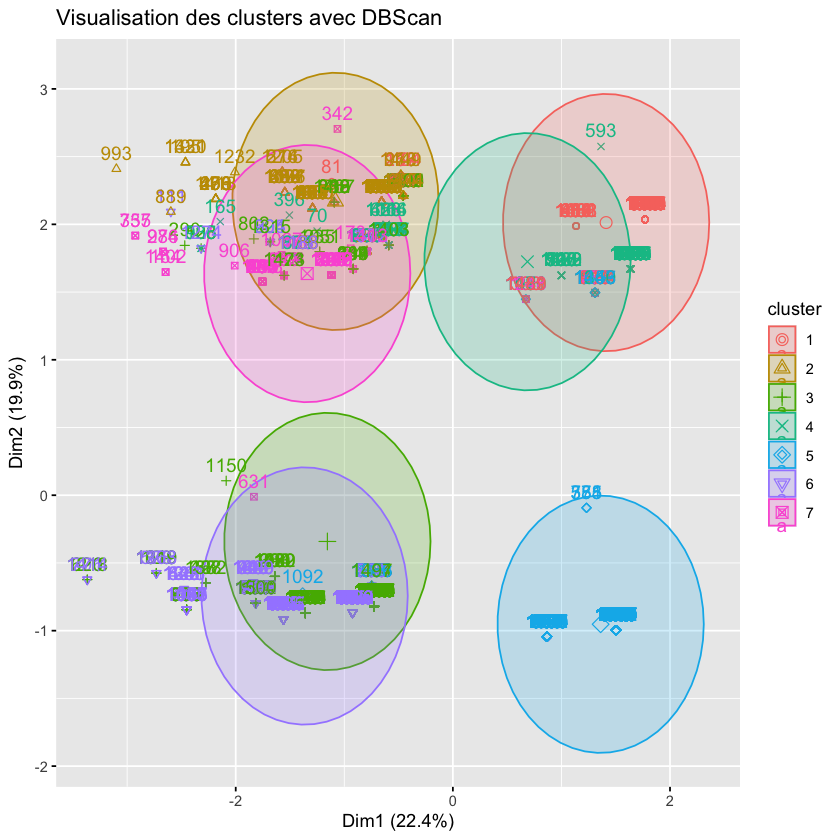

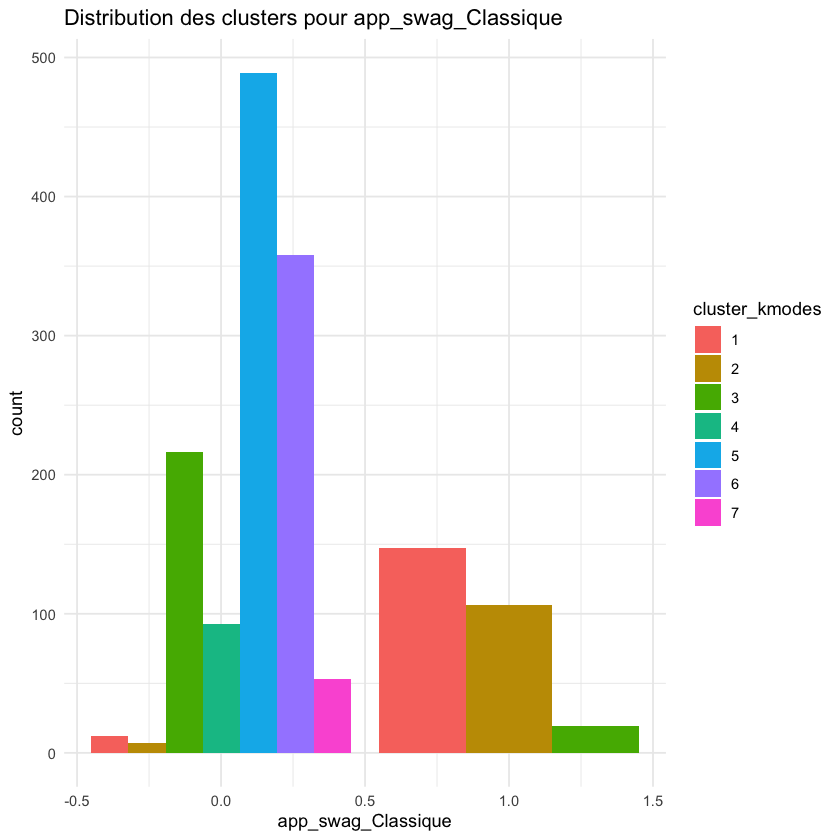

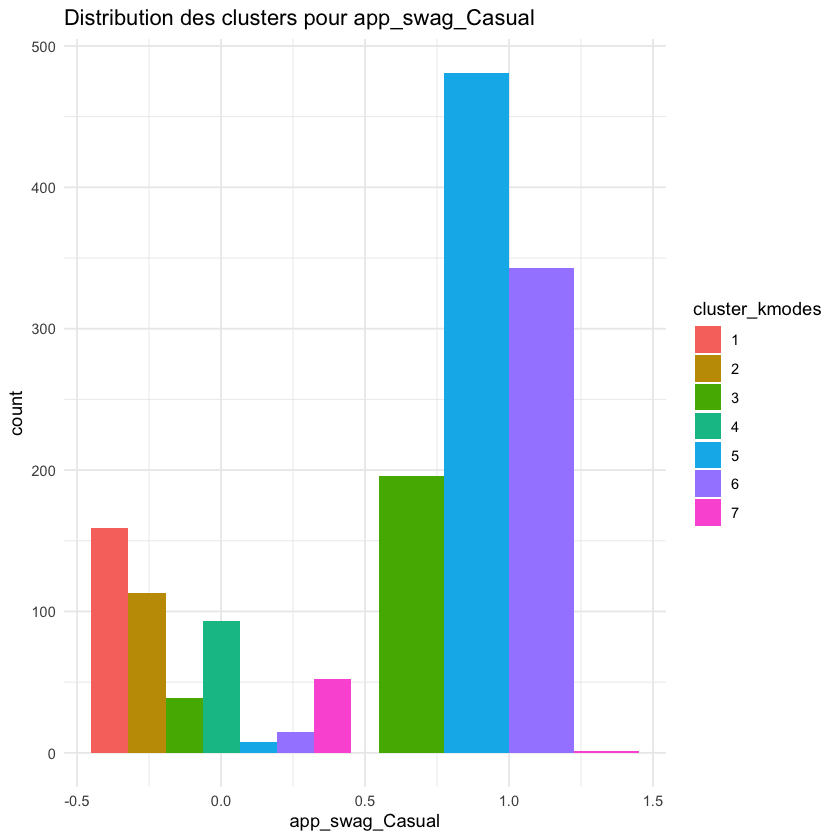

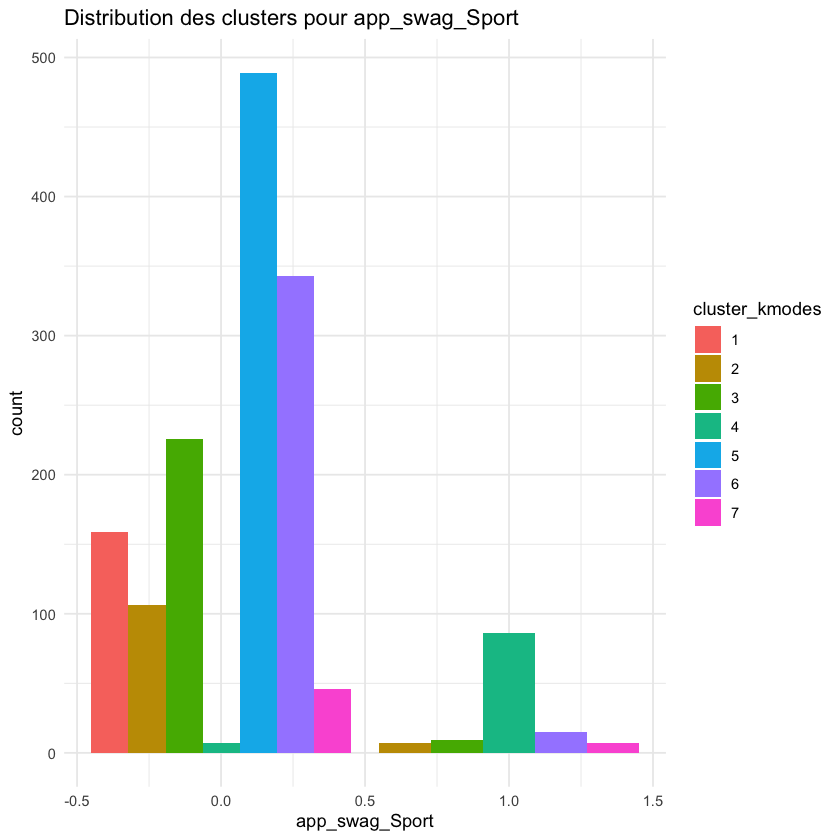

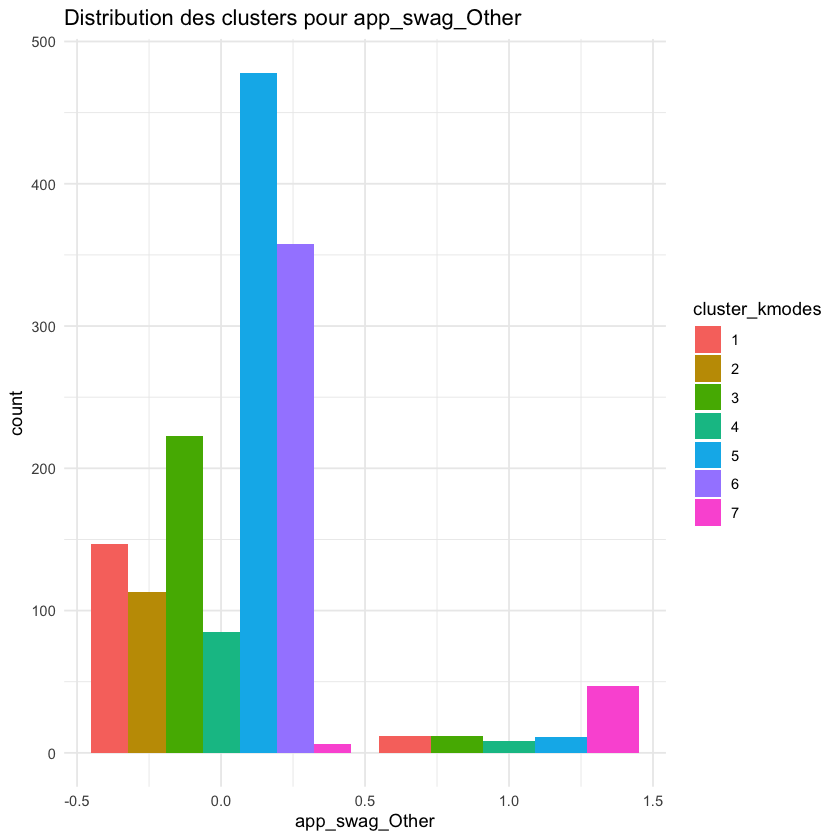

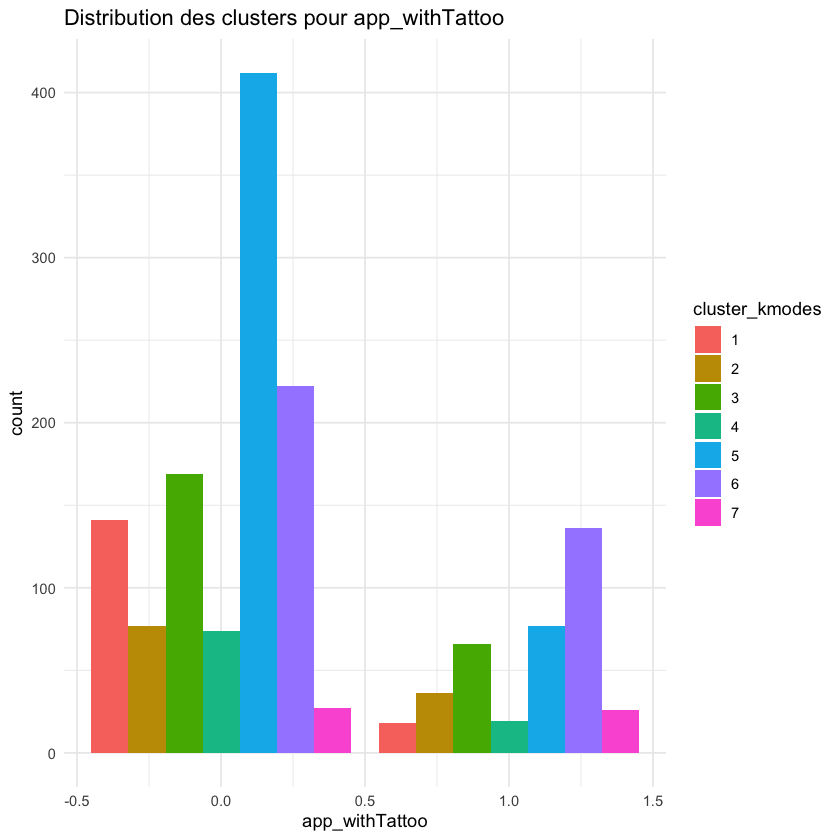

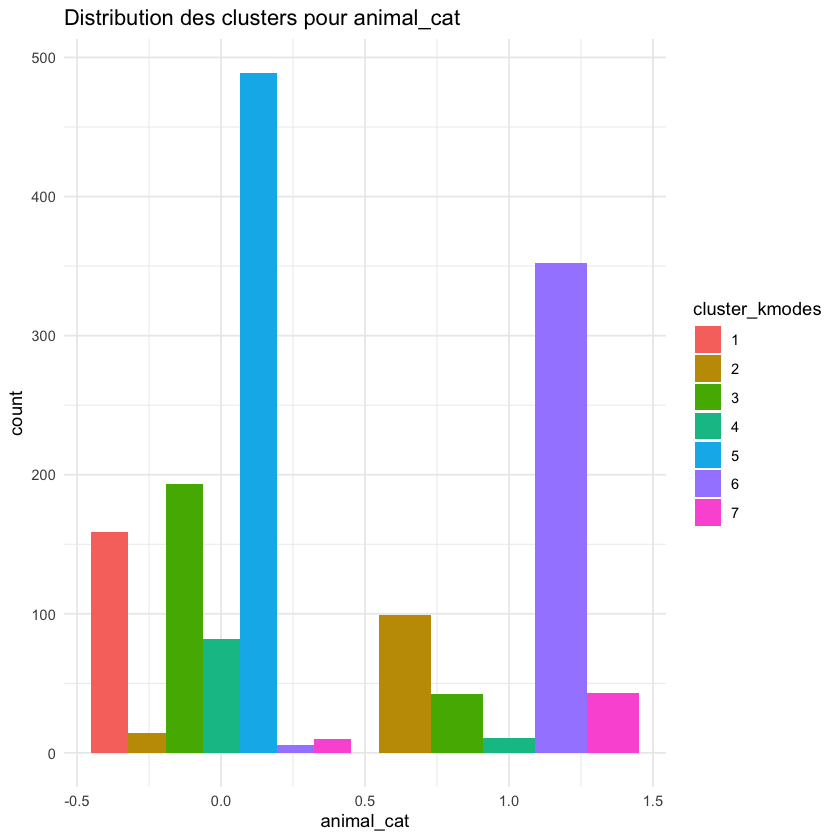

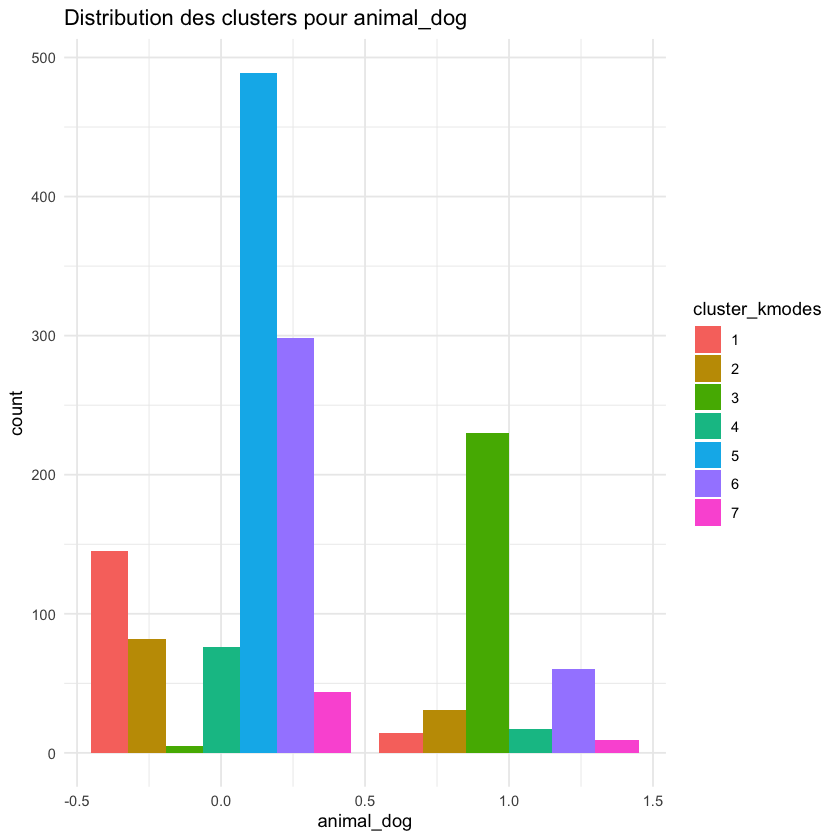

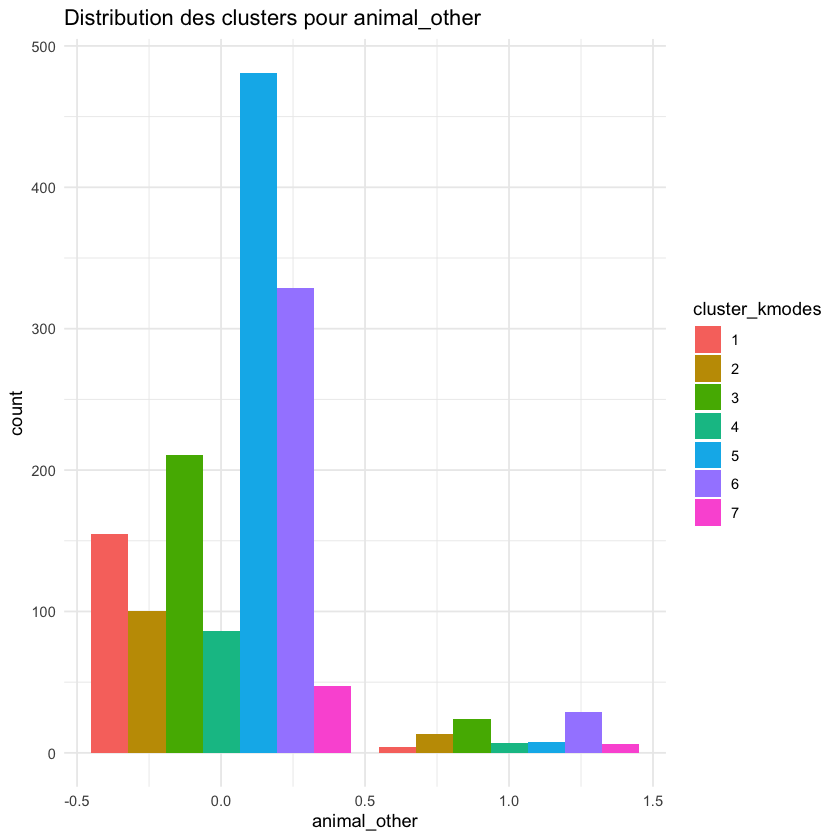

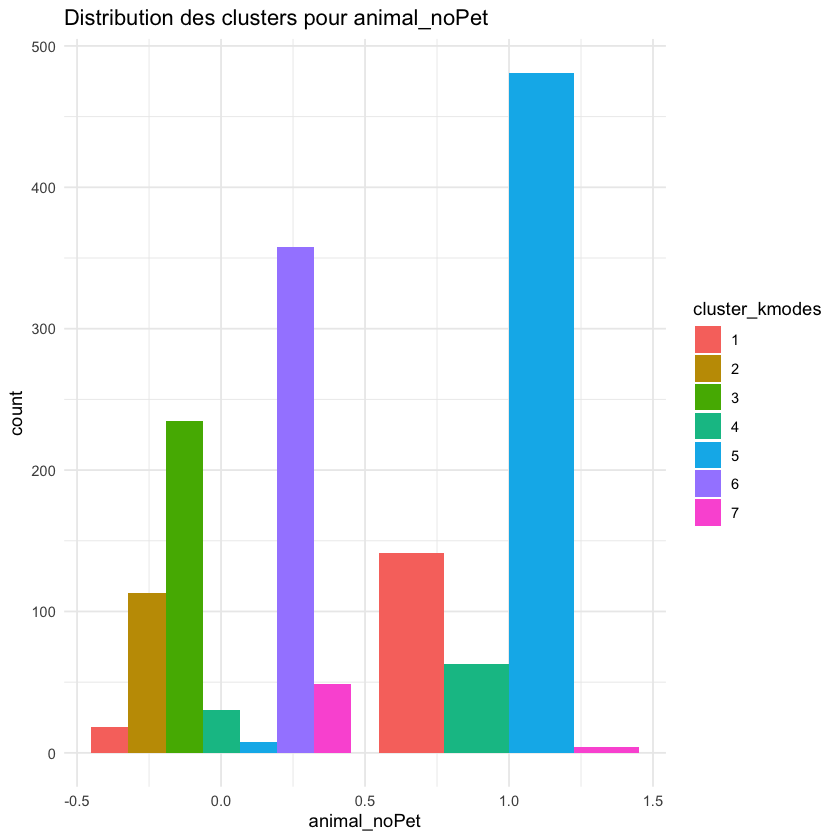

In [142]:
# Visualisation des clusters

# Visualisation des clusters dans l’espace des deux premières dimensions :

# Utilisation de factoextra pour représenter les clusters
fviz_cluster(list(data = df_clust, cluster = df_style$cluster_kmodes), data = df_clust, ellipse.type = "euclid") +
  ggtitle("Visualisation des clusters avec DBScan")

# Graphique par variables

# Variables binaires
g_var_bin <- function(df, nom_var) {
  # Distribution des clusters par var
  g <- ggplot(df, aes(x = .data[[nom_var]], fill = cluster_kmodes)) +
    geom_bar(position = "dodge") +
    ggtitle(paste("Distribution des clusters pour", nom_var)) +
    theme_minimal()
  return(g)
}
g_var_bin(df_style, "app_swag_Classique")
g_var_bin(df_style, "app_swag_Casual")
g_var_bin(df_style, "app_swag_Sport")
g_var_bin(df_style, "app_swag_Other")
g_var_bin(df_style, "app_withTattoo")
g_var_bin(df_style, "animal_cat")
g_var_bin(df_style, "animal_dog")
g_var_bin(df_style, "animal_other")
g_var_bin(df_style, "animal_noPet")

### Clustering avec DBSCAN

Il semble que ça n'ait pas de sens étant donné la nature binaire des données

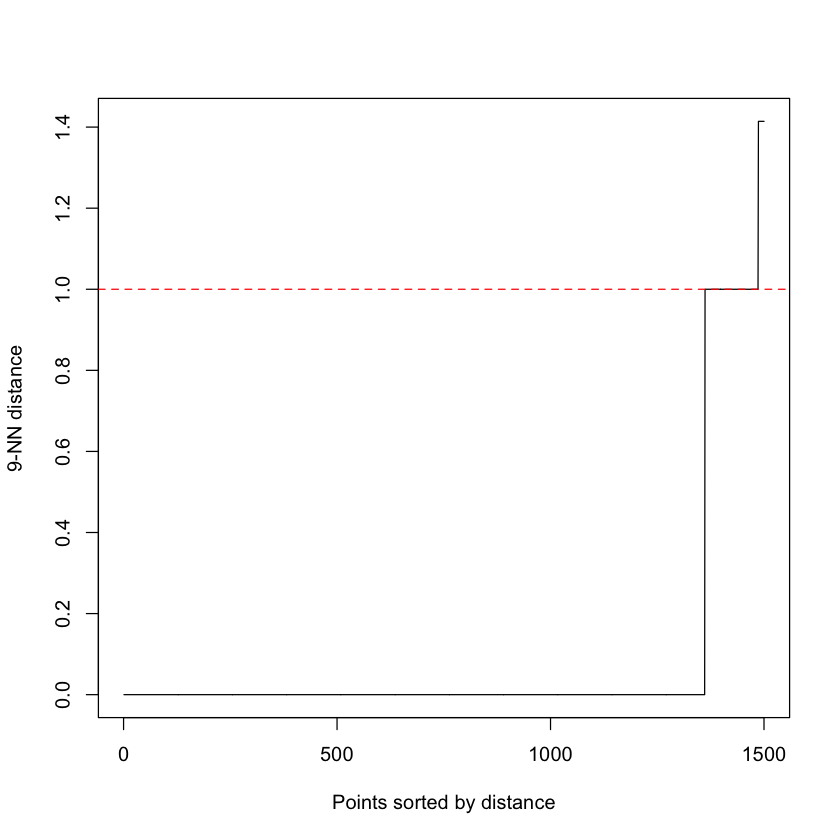

In [132]:
library(dbscan)

# Pour touvre la valeur pour eps : Trouver la distance des 4 plus proches voisins
#
# Dans le graphique abline : 
#   Ajuster h pour estimer `eps`
#   eps correspond à h qui correspond à l'"épaule"
#   le h sert à tracer ne ligne rouge vis-à-vis l'épaule
#
# k devrait être égal à nb_var

#df_scaled <- scale(df_clust)
#head(df_scaled)

kNNdistplot(df_clust, k = 9)
h <- 1
abline(h = h, col = "red", lty = 2)

In [133]:
# Appliquer DBSCAN
dbscan_result <- dbscan(df_clust, eps = h, minPts = 30)

# Afficher les clusters
print(dbscan_result)

dbscan_result$metric
dbscan_result$cluster


DBSCAN clustering for 1500 objects.
Parameters: eps = 1, minPts = 30
Using euclidean distances and borderpoints = TRUE
The clustering contains 4 cluster(s) and 29 noise points.

  0   1   2   3   4 
 29 640 129 560 142 

Available fields: cluster, eps, minPts, metric, borderPoints


[1] "euclidean"

[1] 1 1 2 3 1 1 1 1 3 4 1 2 4 1 1 3 1 4 1 1 1 3 1 3 3 4 3 4 3 2 3 3 1 1 4 4 1
  [38] 1 1 1 1 4 3 1 1 1 3 3 1 1 1 1 3 1 4 3 1 1 1 1 1 1 1 3 3 3 1 1 1 0 3 3 3 1
  [75] 1 4 3 3 3 3 0 3 4 1 1 3 4 1 1 1 2 3 3 0 3 3 3 3 1 1 2 4 3 3 1 3 3 2 1 1 1
 [112] 3 3 1 3 4 3 1 4 1 2 4 1 3 1 1 3 3 1 1 3 1 1 4 1 3 1 2 1 3 1 3 1 1 1 4 0 1
 [149] 3 1 3 3 4 2 4 1 4 3 1 3 1 3 3 1 0 1 1 3 4 1 2 3 0 3 1 1 3 3 2 3 1 0 3 1 3
 [186] 1 2 3 1 1 4 1 3 3 4 3 3 1 1 1 1 1 1 1 1 4 3 4 4 3 1 1 4 3 1 4 3 3 4 3 4 3
 [223] 1 1 3 3 1 1 3 1 1 1 1 3 0 1 4 1 3 1 2 3 0 1 1 3 1 3 1 4 1 3 1 1 1 4 1 4 2
 [260] 3 3 3 4 1 2 1 4 3 1 3 1 1 3 1 1 3 1 3 3 4 0 1 1 1 3 1 3 2 3 0 1 1 3 1 1 1
 [297] 1 1 1 3 1 1 4 0 2 3 2 1 3 1 1 3 2 1 3 3 1 1 3 2 3 1 1 1 1 4 1 1 3 2 1 1 3
 [334] 4 1 3 1 1 1 1 1 1 3 3 3 1 1 1 1 3 1 1 3 3 3 2 0 3 1 2 3 2 1 3 1 3 3 4 4 1
 [371] 1 3 3 4 2 1 1 1 1 2 1 3 3 1 2 1 3 2 4 1 1 3 4 1 1 0 3 1 1 1 1 4 3 4 4 2 1
 [408] 3 3 3 3 2 1 1 4 1 3 1 3 1 1 1 0 3 1 1 3 1 1 3 4 3 3 1 1 3 3 3 4 1 3 1 1 3
 [445] 3 3 3 1 4 3 1 2 2 1 1 4 3 3 1 3 3 3 2 1 1 1 1 3 1 3 3 2 4 1 2 3 3 3 1 3 3
 [482] 3 3 3 3 2 1 4 1 3 3 1 3 3 4 3 3 1 1 1 1 1 3 1 4 2 1 2 3 1 3 3 1 3 1 1 3 3
 [519] 3 3 1 1 1 1 4 1 3 1 0 3 1 1 3 2 1 3 3 4 0 2 3 2 1 4 3 1 4 1 3 1 3 1 1 3 1
 [556] 1 1 3 3 3 3 1 1 1 1 1 1 1 3 3 3 3 3 4 1 1 4 1 3 2 3 3 1 2 3 4 3 1 3 2 2 3
 [593] 3 3 1 3 3 1 1 1 3 2 1 1 1 1 2 3 1 1 3 1 3 4 1 4 3 1 2 1 1 1 4 2 3 1 1 4 1
 [630] 2 1 3 1 1 3 1 4 3 3 3 3 3 3 3 1 1 1 0 3 3 1 2 2 3 4 3 3 0 3 1 3 3 3 3 3 2
 [667] 2 1 4 2 2 2 4 1 3 3 3 3 2 4 3 1 3 2 1 4 3 1 3 1 1 3 1 1 4 1 3 1 1 3 3 3 2
 [704] 1 1 3 3 3 2 3 3 3 1 1 1 2 3 1 3 3 1 3 4 3 1 3 3 1 2 4 1 3 1 1 0 3 3 1 3 1
 [741] 3 3 3 3 4 1 1 1 1 1 3 3 3 1 3 3 1 1 1 1 2 2 3 1 1 1 1 2 2 1 1 1 3 3 1 1 3
 [778] 3 3 1 1 3 3 3 1 3 1 3 3 3 1 4 1 1 3 2 1 2 1 1 2 0 1 3 1 1 3 4 2 2 1 3 3 2
 [815] 4 1 2 1 1 1 3 3 3 3 1 1 2 1 3 1 2 3 2 3 4 4 1 1 3 1 1 1 3 1 1 1 3 1 1 3 1
 [852] 4 1 1 3 1 1 3 1 1 3 1 4 3 3 3 3 3 1 1 1 3 3 4 3 1 3 3 1 3 1 1 1 4 3 3 1 4
 [889] 1 1 2 3 4 2 1 1 1 1 3 3 1 4 1 1 1 1 1 2 4 1 1 4 2 3 3 1 1 4 2 3 3 4 2 1 1
 [926] 1 4 3 3 1 3 3 3 3 1 1 3 1 2 3 3 1 3 2 1 3 0 3 3 2 1 1 1 1 3 1 1 3 2 1 3 1
 [963] 1 3 3 3 1 1 2 3 1 3 1 3 1 4 2 4 1 4 1 3 3 2 3 1 1 3 3 3 3 3 4 3 2 3 1 4 3
[1000] 4 2 4 3 3 3 3 3 1 1 2 3 3 3 1 2 3 1 2 1 3 3 1 2 3 1 4 3 3 1 3 2 1 1 3 1 4
[1037] 1 1 3 1 3 1 1 1 1 3 3 3 1 1 0 3 1 3 3 4 3 1 3 1 4 3 3 0 1 2 0 3 3 3 1 1 1
[1074] 1 1 3 4 3 1 3 1 2 1 1 1 1 1 1 3 1 1 1 3 3 3 3 1 3 3 1 3 2 1 1 1 1 3 3 3 1
[1111] 3 3 1 2 3 0 3 3 1 1 1 1 3 0 3 1 3 4 1 1 3 3 4 1 1 4 3 1 3 1 3 3 1 3 1 3 3
[1148] 3 1 1 3 1 4 2 1 1 1 1 4 1 3 4 3 1 3 4 3 3 1 3 1 1 4 1 1 2 1 1 4 1 1 1 2 3
[1185] 3 3 1 1 1 1 3 1 3 3 3 4 1 1 1 3 3 1 1 1 4 3 3 3 3 3 1 1 3 3 1 1 3 1 1 3 3
[1222] 3 1 3 3 4 3 3 2 3 1 4 3 2 3 3 1 1 3 4 3 1 1 1 1 1 3 3 1 3 1 4 3 3 3 1 3 2
[1259] 3 4 1 1 4 3 4 3 2 2 3 3 3 3 3 1 3 1 1 3 1 1 1 3 1 3 3 1 1 1 4 2 3 1 1 1 3
[1296] 3 3 3 3 3 4 1 1 1 1 1 1 1 1 1 3 1 1 3 1 0 1 1 1 4 2 4 1 1 1 1 1 1 3 3 2 3
[1333] 3 2 3 3 1 3 1 3 1 1 3 1 1 2 3 3 3 4 4 2 1 3 3 1 1 3 2 1 2 1 1 1 3 1 1 3 1
[1370] 3 4 1 2 1 3 1 3 2 1 3 3 1 1 1 3 3 1 3 3 1 3 1 1 3 3 3 1 3 1 2 3 1 1 3 4 1
[1407] 2 3 1 3 1 2 1 1 3 1 1 4 1 1 1 3 3 4 1 2 3 1 2 3 4 2 1 3 3 3 4 1 1 3 3 1 3
[1444] 4 3 1 3 1 4 3 3 3 4 1 1 1 3 1 1 3 3 3 3 3 3 1 4 2 3 3 1 3 0 3 1 1 1 1 3 3
[1481] 3 1 1 3 1 3 3 1 3 1 2 1 1 3 3 2 1 2 1 1

In [135]:
# Ajouter les résultats des clusters aux données
df_style$cluster_dbscan <- as.factor(dbscan_result$cluster)

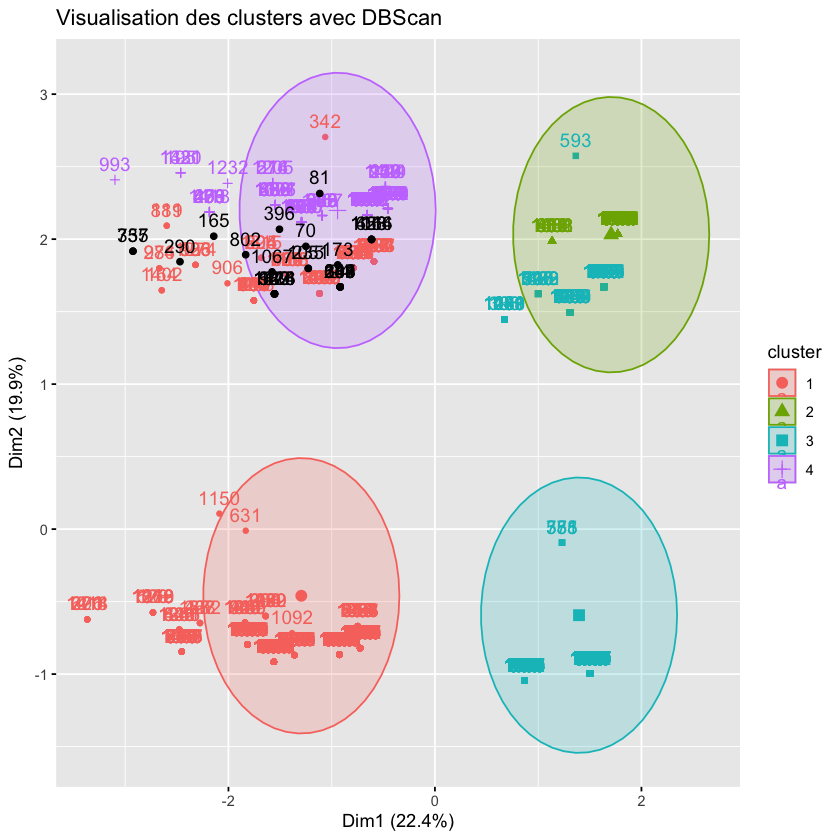

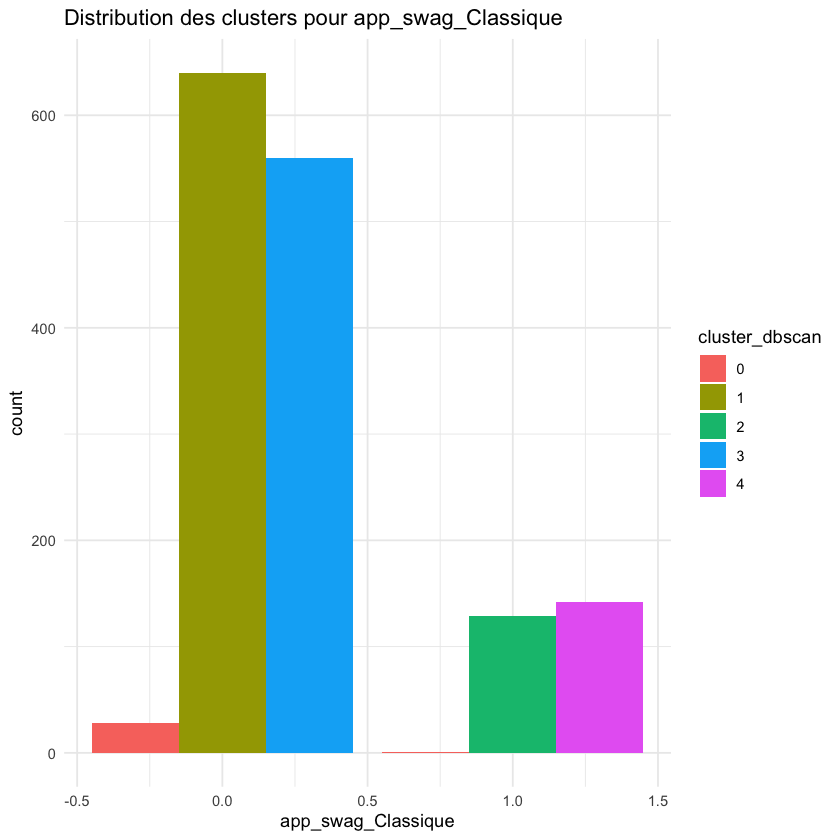

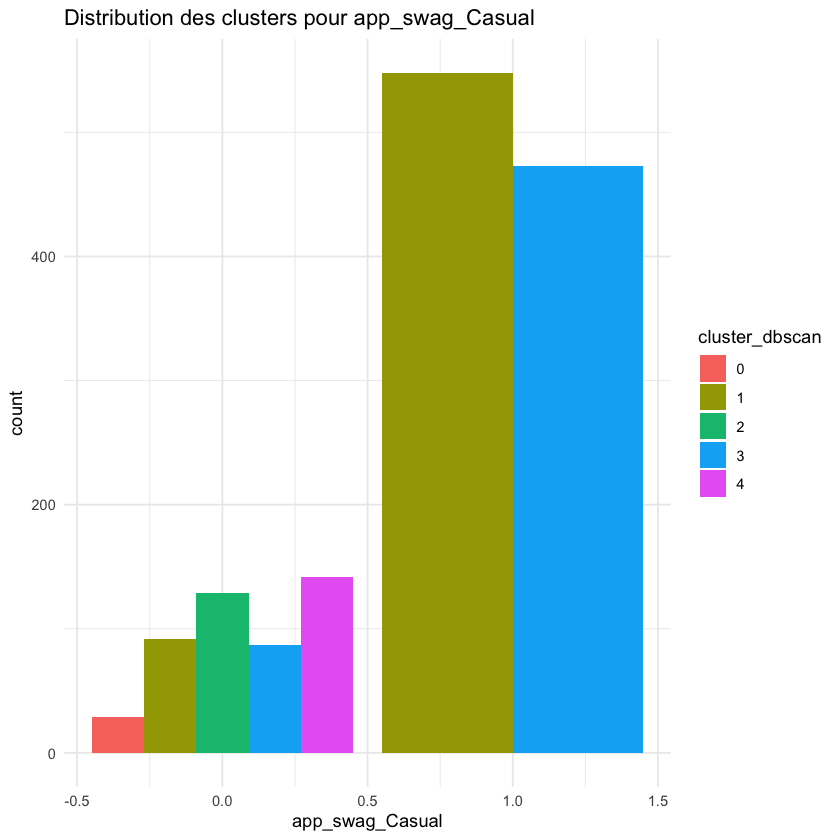

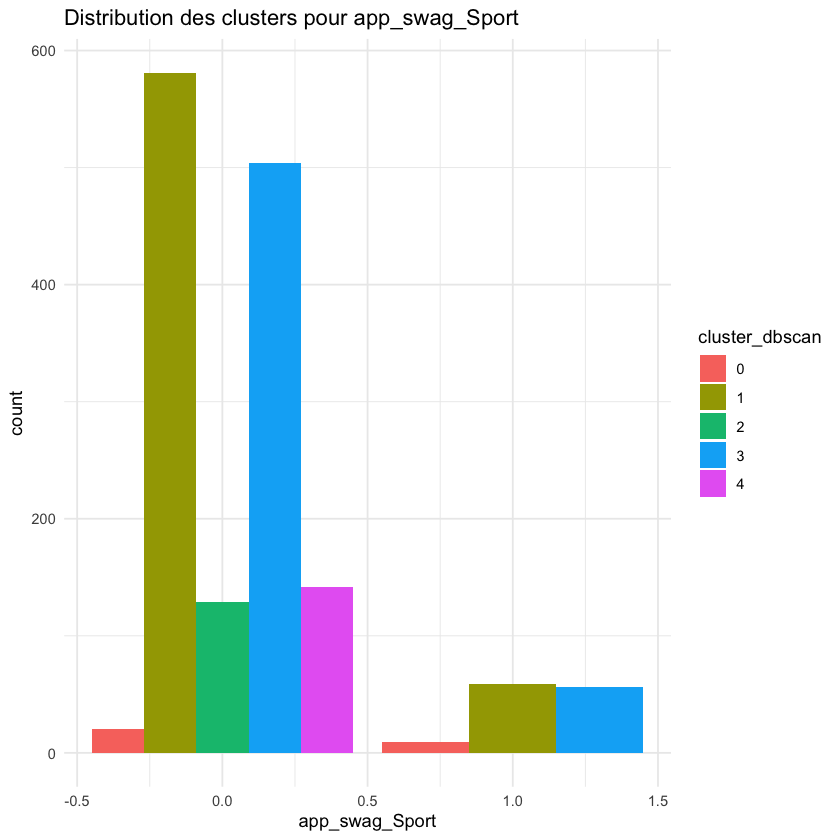

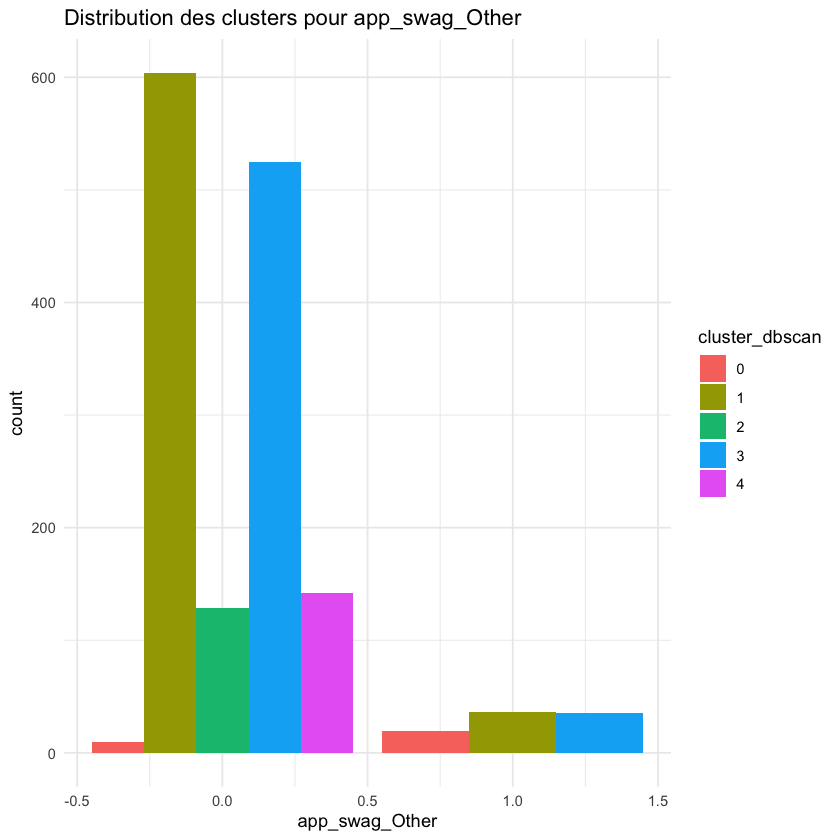

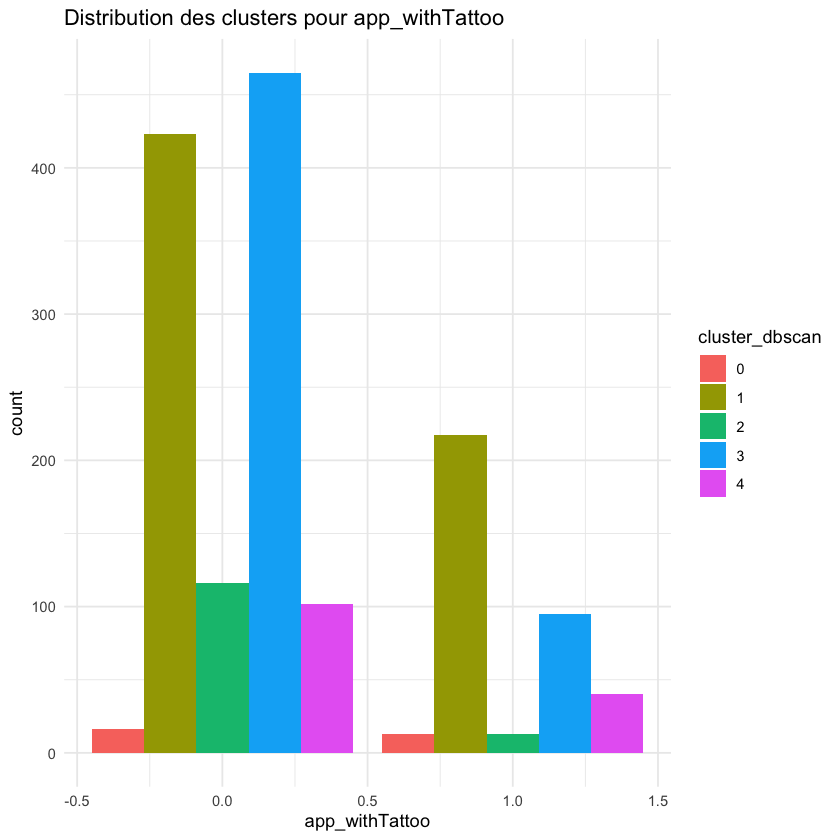

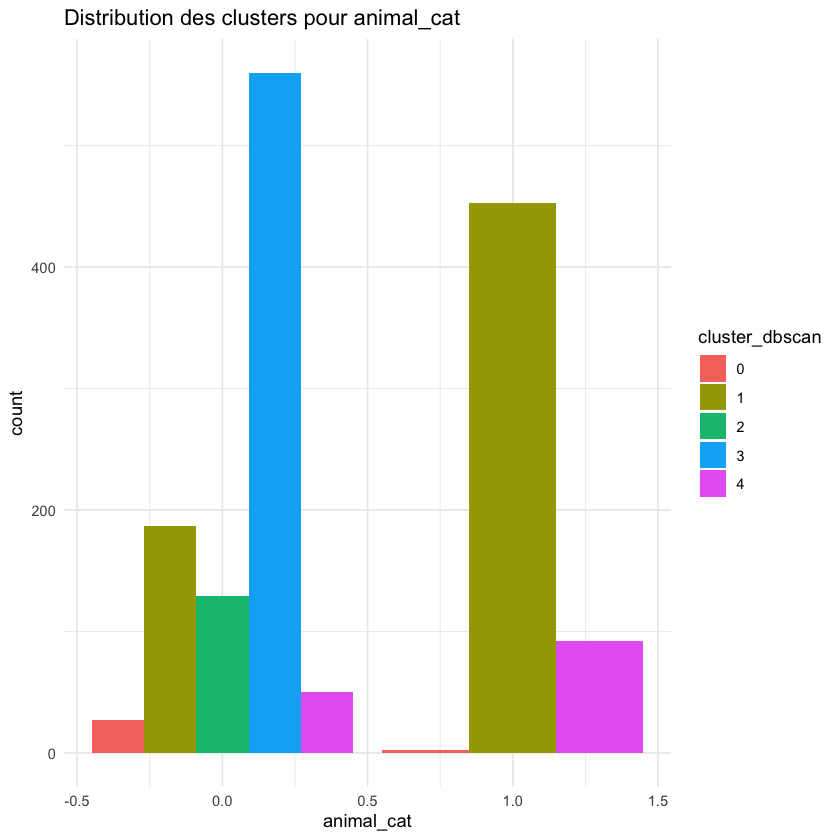

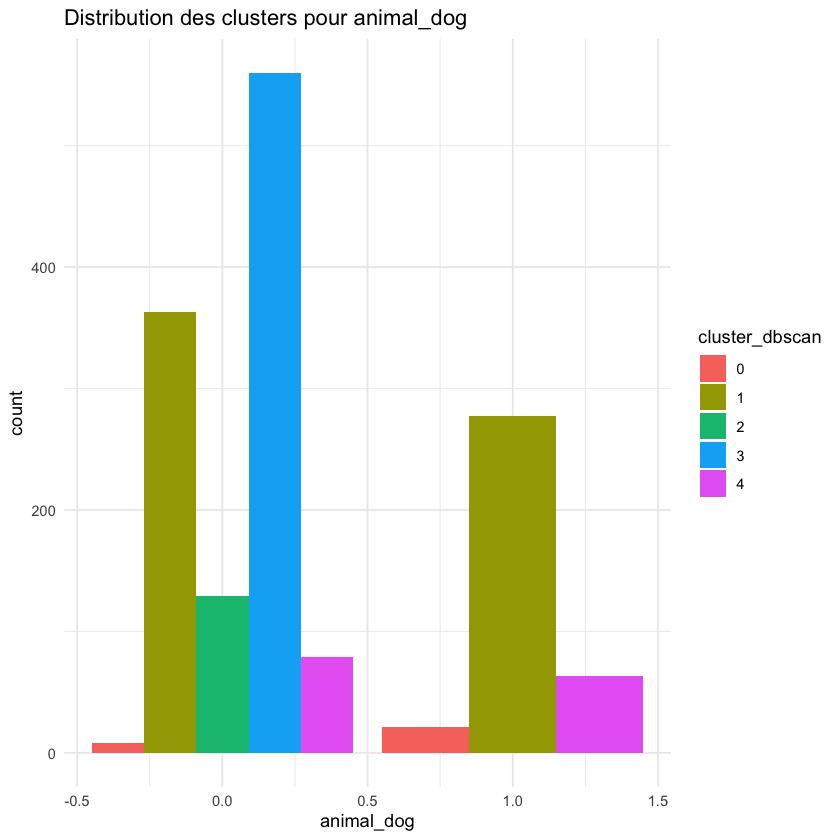

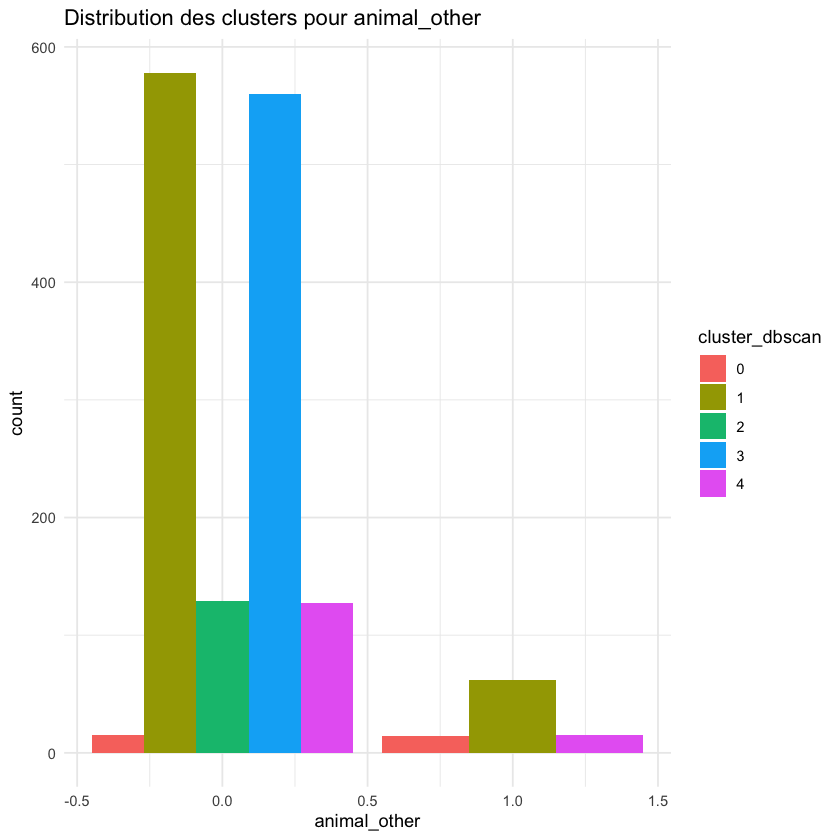

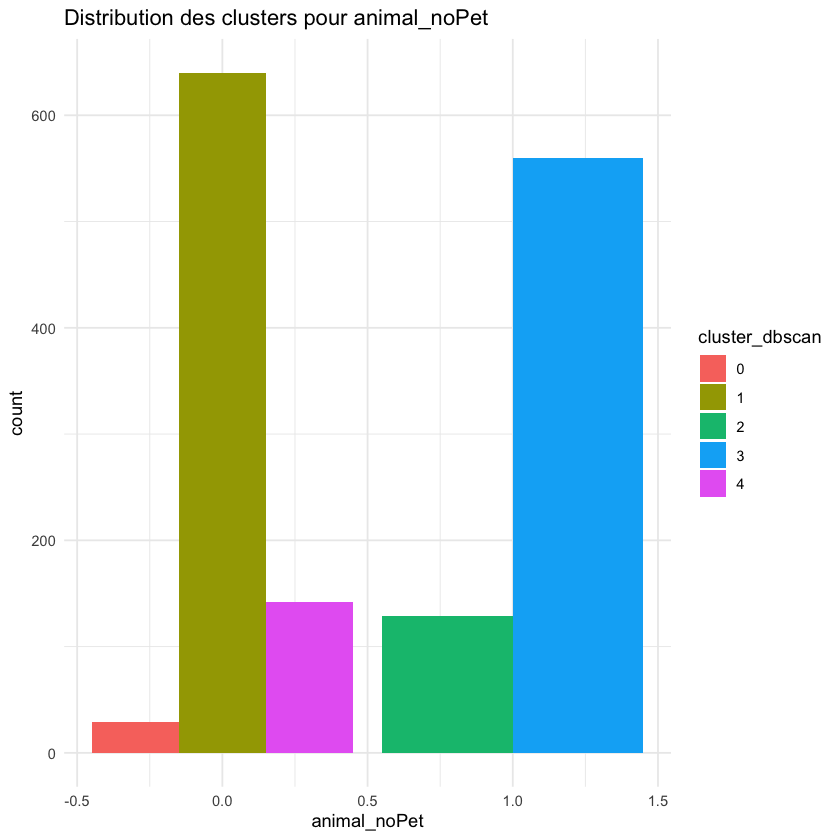

In [138]:
# Visualisation des clusters

# Visualisation des clusters dans l’espace des deux premières dimensions :

# Utilisation de factoextra pour représenter les clusters
fviz_cluster(dbscan_result, data = df_clust, ellipse.type = "euclid") +
  ggtitle("Visualisation des clusters avec DBScan")

# Graphique par variables

# Variables binaires
g_var_bin <- function(df, nom_var) {
  # Distribution des clusters par var
  g <- ggplot(df, aes(x = .data[[nom_var]], fill = cluster_dbscan)) +
    geom_bar(position = "dodge") +
    ggtitle(paste("Distribution des clusters pour", nom_var)) +
    theme_minimal()
  return(g)
}
g_var_bin(df_style, "app_swag_Classique")
g_var_bin(df_style, "app_swag_Casual")
g_var_bin(df_style, "app_swag_Sport")
g_var_bin(df_style, "app_swag_Other")
g_var_bin(df_style, "app_withTattoo")
g_var_bin(df_style, "animal_cat")
g_var_bin(df_style, "animal_dog")
g_var_bin(df_style, "animal_other")
g_var_bin(df_style, "animal_noPet")

### Reste du code

In [ ]:
library(cluster)
dissimilarity_matrix <- daisy(df_scaled, metric = "gower")

In [ ]:
dissimilarity_matrix

In [ ]:
# Création d'un tableau des fréquences
combinations <- as.data.frame(table(df_scaled))

# Filtrer uniquement les combinaisons ayant au moins une occurrence
combinations <- combinations[combinations$Freq > 0, ]

print(combinations)

library(ggplot2)

# Créer un identifiant pour chaque combinaison
combinations$combination <- apply(combinations[, 1:9], 1, paste, collapse = "")

# Visualiser les fréquences
ggplot(combinations, aes(x = reorder(combination, -Freq), y = Freq)) +
  geom_bar(stat = "identity") +
  labs(x = "Combinaisons", y = "Fréquence") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [ ]:
# Appliquer DBSCAN
dbscan_result <- dbscan(df_scaled, eps = 1, minPts = 30)

# Afficher les clusters
print(dbscan_result)

# Visualisation
# library(ggplot2)
# df_scaled$cluster <- as.factor(dbscan_result$cluster)
# ggplot(df_scaled, aes(x = mpg, y = disp, color = cluster)) +
#   geom_point(size = 3) +
#   labs(title = "DBSCAN Clustering", color = "Cluster")

In [16]:
# Appliquer PCA pour réduire la dimensionnalité
pca_result <- prcomp(df_scaled, scale = TRUE)

# Extraire les 2 premières composantes principales pour le graphique
pca_data <- data.frame(pca_result$x[, 1:2])  # Première et deuxième composantes principales

# Ajouter les résultats de DBSCAN aux données PCA
pca_data$cluster <- as.factor(dbscan_result$cluster)

In [ ]:
library(ggplot2)

# Créer un graphique des clusters DBSCAN
ggplot(pca_data, aes(x = PC1, y = PC2, color = cluster)) +
  geom_point(size = 3) +
  labs(title = "DBSCAN Clustering avec PCA",
       x = "Composante Principale 1",
       y = "Composante Principale 2",
       color = "Cluster") +
  theme_minimal()

In [ ]:
library(Rtsne)

# Appliquer t-SNE pour réduire à 2 dimensions
tsne_result <- Rtsne(df_scaled, dims = 2)

# Créer un dataframe avec les résultats t-SNE
tsne_data <- data.frame(tsne_result$Y)
tsne_data$cluster <- as.factor(dbscan_result$cluster)

# Visualisation t-SNE
ggplot(tsne_data, aes(x = V1, y = V2, color = cluster)) +
  geom_point(size = 3) +
  labs(title = "DBSCAN Clustering avec t-SNE",
       x = "t-SNE Dimension 1",
       y = "t-SNE Dimension 2",
       color = "Cluster") +
  theme_minimal()

In [ ]:
library(dplyr)
# Ajouter les résultats des clusters aux données
df_scaled$cluster <- as.factor(dbscan_result$cluster)
# Calculer la moyenne et l'écart-type pour chaque variable par cluster
summary_clusters <- df_scaled %>%
  group_by(cluster) %>%
  summarise(across(starts_with("app_") | starts_with("animal_"), list(mean = mean, sd = sd), .names = "{.col}_{.fn}"))

# Afficher le résumé des statistiques pour chaque cluster
View(summary_clusters)